![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png)

# <center>Cars4U Project Spark

**Context**

There is a huge demand for used cars in the Indian Market today. As sales of new cars have slowed down in the recent past, the pre-owned car market has continued to grow over the past years and is larger than the new car market now. Cars4U is a budding tech start-up that aims to find footholes in this market.

In 2018-19, while new car sales were recorded at 3.6 million units, around 4 million second-hand cars were bought and sold. There is a slowdown in new car sales and that could mean that the demand is shifting towards the pre-owned market. In fact, some car sellers replace their old cars with pre-owned cars instead of buying new ones. Unlike new cars, where price and supply are fairly deterministic and managed by OEMs (Original Equipment Manufacturer / except for dealership level discounts which come into play only in the last stage of the customer journey), used cars are very different beasts with huge uncertainty in both pricing and supply. Keeping this in mind, the pricing scheme of these used cars becomes important in order to grow in the market.

As a senior data scientist at Cars4U, you have to come up with a pricing model that can effectively predict the price of used cars and can help the business in devising profitable strategies using differential pricing. For example, if the business knows the market price, it will never sell anything below it.

**Objective**

To explore and visualize the dataset, build a linear regression model to predict the prices of used cars, and generate a set of insights and recommendations that will help the business.

### Initial Imports

In [1]:
import pyspark
from pyspark.sql import SparkSession

# Establish basic entry point of all functionality in Apache Spark
spark = SparkSession.builder.master("local[2]") \
                    .appName('clean_eda_lin_reg') \
                    .getOrCreate()

21/09/27 23:31:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Load Dataset

In [2]:
# File path of dataset
csvFile = "Resources/used_cars_data.csv"

# Load CSV in Spark DataFrame
used_cars_original_df = spark.read.csv(
    csvFile,                       # Creates a DataFrame from CSV after reading in the file
    header = True,                 # Use first line of all files as header
    inferSchema = True             # Automatically infer data types
)

**Data Dictionary**

 - S.No.: Serial number
 - Name: Name of the car which includes brand name and model name
 - Location: Location in which the car is being sold or is available for purchase (cities)
 - Year: Manufacturing year of the car
 - Kilometers_driven: The total kilometers driven in the car by the previous owner(s) in km
 - Fuel_Type: The type of fuel used by the car (Petrol, Diesel, Electric, CNG, LPG)
 - Transmission: The type of transmission used by the car (Automatic/Manual)
 - Owner: Type of ownership
 - Mileage: The standard mileage offered by the car company in kmpl or km/kg
 - Engine: The displacement volume of the engine in CC
 - Power: The maximum power of the engine in bhp
 - Seats: The number of seats in the car
 - New_Price: The price of a new car of the same model in INR Lakhs (1 Lakh INR = 100,000 INR)
 - Price: The price of the used car in INR Lakhs

In [3]:
# Display Spark DataFrame
used_cars_original_df.show()

+-----+--------------------+----------+----+-----------------+---------+------------+----------+----------+-------+----------+-----+----------+-----+
|S.No.|                Name|  Location|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|   Mileage| Engine|     Power|Seats| New_Price|Price|
+-----+--------------------+----------+----+-----------------+---------+------------+----------+----------+-------+----------+-----+----------+-----+
|    0|Maruti Wagon R LX...|    Mumbai|2010|            72000|      CNG|      Manual|     First|26.6 km/kg| 998 CC| 58.16 bhp|    5|      null| 1.75|
|    1|Hyundai Creta 1.6...|      Pune|2015|            41000|   Diesel|      Manual|     First|19.67 kmpl|1582 CC| 126.2 bhp|    5|      null| 12.5|
|    2|        Honda Jazz V|   Chennai|2011|            46000|   Petrol|      Manual|     First| 18.2 kmpl|1199 CC|  88.7 bhp|    5| 8.61 Lakh|  4.5|
|    3|   Maruti Ertiga VDI|   Chennai|2012|            87000|   Diesel|      Manual|     First|20.7

In [4]:
# Get Shape of DataFrame
used_cars_original_df.count(), len(used_cars_original_df.columns)

(7253, 14)

In [5]:
# Create a copy to avoid changing original dataset
used_cars_df = used_cars_original_df

**Observations**
 - `S.No.` should be removed as it is just an index column and provides not meaningful insights
 - `name` is very specific and maybe should be broken up
 - `Mileage`, `Engine` and `Power` have integers and strings in the column that need to be separated and or conversions done 
 - `New_Price` seems to have a lot of missing values and needs further investigation

### Check and Clean Data

In [6]:
# Number of Partitions
print('Number of Partitions: {}'.format(used_cars_df.rdd.getNumPartitions()))

Number of Partitions: 1


In [7]:
# Drop S.No. column
used_cars_df = used_cars_df.drop('S.No.')

In [8]:
# Display Schema
used_cars_df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Kilometers_Driven: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner_Type: string (nullable = true)
 |-- Mileage: string (nullable = true)
 |-- Engine: string (nullable = true)
 |-- Power: string (nullable = true)
 |-- Seats: integer (nullable = true)
 |-- New_Price: string (nullable = true)
 |-- Price: double (nullable = true)



In [9]:
# For loop to display null values in Spark Dataframe
print('     Number of Null Values in Columns')
for col in used_cars_df.columns:
    if used_cars_df[used_cars_df[col].isNull()].count() > 0:
        print(f'{col}:')
        print(used_cars_df[used_cars_df[col].isNull()].count())

     Number of Null Values in Columns
Mileage:
2
Engine:
46
Power:
175
Seats:
53
New_Price:
6247
Price:
1234


**Observations**
 - `New_Price` is missing almost all of its values and should be dropped as it will create artificial data to fillin with mean and it would be to time consuming to get the data
 - `Price` is the target column and rows with missing target column values should be dropped

In [10]:
import pyspark.sql.functions as f

# Check for duplicate rows
used_cars_df.groupBy(used_cars_df.columns).count().filter("count > 1").show()
used_cars_df.groupBy(used_cars_df.columns).count().filter("count > 1").select(f.sum('count')).show()

+-------------------+--------+----+-----------------+---------+------------+----------+---------+-------+-------+-----+---------+-----+-----+
|               Name|Location|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|  Mileage| Engine|  Power|Seats|New_Price|Price|count|
+-------------------+--------+----+-----------------+---------+------------+----------+---------+-------+-------+-----+---------+-----+-----+
|Honda City 1.5 E MT|  Mumbai|2010|            52000|   Petrol|      Manual|     First|17.0 kmpl|1497 CC|118 bhp|    5|     null| null|    2|
+-------------------+--------+----+-----------------+---------+------------+----------+---------+-------+-------+-----+---------+-----+-----+



+----------+
|sum(count)|
+----------+
|         2|
+----------+



**Observations**
 - It is possible that these are not duplicate sales and checking the distribution of features to see how likely they are duplicates might be needed but since the target column is a null value it will be dropped anyway


In [11]:
# Drop New_Price column
used_cars_df = used_cars_df.drop('New_Price')

In [12]:
# Drop N/As in target column
used_cars_df = used_cars_df.na.drop(subset=["Price"])

### Data Preprocessing
 - `Mileage`, `Engine` and `Power` will be split to remove characters, changed to integer and converted to same unit of measurement if neccesary 

**Mileage**

In [13]:
# split Mileage on space
split_mileage_col = pyspark.sql.functions.split(used_cars_df['Mileage'], ' ')

used_cars_df = used_cars_df \
        .withColumn('Mileage_num', split_mileage_col.getItem(0)) \
        .withColumn('mileage_unit', split_mileage_col.getItem(1))

In [14]:
# check different fuel types to make sure no conversions are needed
used_cars_df.groupBy('mileage_unit').count().show()

+------------+-----+
|mileage_unit|count|
+------------+-----+
|       km/kg|   66|
|        null|    2|
|        kmpl| 5951|
+------------+-----+



In [15]:
# check to make sure fuel mileage types match
used_cars_df.groupBy('Fuel_Type', 'mileage_unit').count().show()

+---------+------------+-----+
|Fuel_Type|mileage_unit|count|
+---------+------------+-----+
|      CNG|       km/kg|   56|
|   Petrol|        kmpl| 2746|
|   Diesel|        kmpl| 3205|
| Electric|        null|    2|
|      LPG|       km/kg|   10|
+---------+------------+-----+



**Observations**

 - No conversions are needed as they are in kilometers for the different fuel types
 - the fuel type electric should be dropped as there are only 2 instances and will not come up with good predictions and a good chance it doesnt end up in the training data.
 - Drop column with kmpl or km/kg units as fuel type already defines this and would be double counting it

In [16]:
# Drop rows with electric in Fuel_Type
used_cars_df = used_cars_df.where("Fuel_Type!='Electric'")

In [17]:
# Drop Mileage column to be replaced with Mileage_num
used_cars_df = used_cars_df.drop('Mileage')

# Drop mileage_unit column
used_cars_df = used_cars_df.drop('mileage_unit')

In [18]:
# Change column name to Mileage
used_cars_df = used_cars_df.withColumnRenamed('Mileage_num', 'Mileage')

In [19]:
from pyspark.sql.functions import col, trim, lower
# Change data type
used_cars_df = used_cars_df.withColumn("Mileage",col("Mileage").cast("int"))

**Engine**
 - `Engine` check to make sure only CC is in and no conversions are needed
 - `Engine` should be converted to an integer

In [20]:
# split Engine on space
split_engine_col = pyspark.sql.functions.split(used_cars_df['Engine'], ' ')

used_cars_df = used_cars_df \
        .withColumn('Engine_num', split_engine_col.getItem(0)) \
        .withColumn('Engine_unit', split_engine_col.getItem(1))

In [21]:
# check different Engine types to make sure no conversions are needed
used_cars_df.groupBy('Engine_unit').count().show()

+-----------+-----+
|Engine_unit|count|
+-----------+-----+
|       null|   36|
|         CC| 5981|
+-----------+-----+



**Observations**

 - No conversions are needed
 - CC should be dropped as it provides no meaningful insights

In [22]:
# Drop Engine column to be replaced with Mileage_num
used_cars_df = used_cars_df.drop('Engine')

# Drop Engine_unit column
used_cars_df = used_cars_df.drop('Engine_unit')

In [23]:
# Change column name to Engine
used_cars_df = used_cars_df.withColumnRenamed('Engine_num', 'Engine')

In [24]:
# Change data type
used_cars_df = used_cars_df.withColumn("Engine",col("Engine").cast("int"))

**Power**
 - `Power` check to make sure only bhp is in and no conversions are needed
 - `Power` should be converted to an integer

In [25]:
# split Power on space
split_power_col = pyspark.sql.functions.split(used_cars_df['Power'], ' ')

used_cars_df = used_cars_df \
        .withColumn('Power_num', split_power_col.getItem(0)) \
        .withColumn('Power_unit', split_power_col.getItem(1))

In [26]:
# check different Engine types to make sure no conversions are needed
used_cars_df.groupBy('Power_unit').count().show()

+----------+-----+
|Power_unit|count|
+----------+-----+
|      null|  143|
|       bhp| 5874|
+----------+-----+



**Observations**

 - No conversions are needed
 - bhp should be dropped as it provides no meaningful insights

In [27]:
# Drop Power column to be replaced with Power_num
used_cars_df = used_cars_df.drop('Power')

# Drop Power_unit column
used_cars_df = used_cars_df.drop('Power_unit')

In [28]:
# Change column name to Power
used_cars_df = used_cars_df.withColumnRenamed('Power_num', 'Power')

In [29]:
# Change data type
used_cars_df = used_cars_df.withColumn("Power",col("Power").cast("int"))

### Feature Engineering
 - `Name` is very specific and can be broken out into brands and models
 - Models can be broken classes such as Economy, Mid Range, Luxury and Exotic

**Brand and Model**

In [30]:
# Get the number of unique values in Name
print('Number of unique values in Name column:')
used_cars_df.select('Name').distinct().count()

Number of unique values in Name column:


1874

In [31]:
# split Name on space
split_name_col = pyspark.sql.functions.split(used_cars_df['Name'], ' ')

used_cars_df = used_cars_df \
        .withColumn('Brand', split_name_col.getItem(0)) \
        .withColumn('Model_1', split_name_col.getItem(1))

In [32]:
# display Spark dataframe
used_cars_df.show()

+--------------------+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-------------+-------+
|                Name|  Location|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|        Brand|Model_1|
+--------------------+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-------------+-------+
|Maruti Wagon R LX...|    Mumbai|2010|            72000|      CNG|      Manual|     First|    5| 1.75|     26|   998|   58|       Maruti|  Wagon|
|Hyundai Creta 1.6...|      Pune|2015|            41000|   Diesel|      Manual|     First|    5| 12.5|     19|  1582|  126|      Hyundai|  Creta|
|        Honda Jazz V|   Chennai|2011|            46000|   Petrol|      Manual|     First|    5|  4.5|     18|  1199|   88|        Honda|   Jazz|
|   Maruti Ertiga VDI|   Chennai|2012|            87000|   Diesel|      Manual|     First|    7|  6.0|     20|  1248|   88| 

**Observations**
 - Notice that Land is unique but all models will be Rover which is incorrect
 - A more advanced filtering should be done

In [33]:
# Add third split to dataframe to capture Land Rover model
used_cars_df = used_cars_df \
        .withColumn('Model_2', split_name_col.getItem(2))

In [34]:
from pyspark.sql.functions import when

# Clear out third split if not Rover on second split
used_cars_df = used_cars_df.withColumn("Model_2", when(used_cars_df.Model_1 != "Rover","")
                                 .otherwise(used_cars_df.Model_2))

In [35]:
# Clear out Rover on second split
used_cars_df = used_cars_df.withColumn("Model_1", when(used_cars_df.Model_1 == "Rover","")
                                 .otherwise(used_cars_df.Model_1))

In [36]:
# Add Rover to Brand name to create Land Rover
used_cars_df = used_cars_df.withColumn("Brand", when(used_cars_df.Brand == "Land","Land Rover")
                                 .otherwise(used_cars_df.Brand))

In [37]:
from pyspark.sql.functions import concat,concat_ws

# concat models
used_cars_df = used_cars_df.withColumn('Model', concat_ws('', col('Model_1'), col('Model_2')))

In [38]:
# Drop Name column
used_cars_df = used_cars_df.drop('Name')

# Drop Model_1 column
used_cars_df = used_cars_df.drop('Model_1')

# Drop Model_2 column
used_cars_df = used_cars_df.drop('Model_2')

In [39]:
# Get the number of unique values in Brand
print('Number of unique values in Brand column:')
used_cars_df.select('Brand').distinct().count()

Number of unique values in Brand column:


31

In [40]:
# Get the number of unique values in Model
print('Number of unique values in Model column:')
used_cars_df.select('Model').distinct().count()

Number of unique values in Model column:


212

In [41]:
# Display Spark DataFrame
used_cars_df.show()

+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-------------+----------+
|  Location|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|        Brand|     Model|
+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-------------+----------+
|    Mumbai|2010|            72000|      CNG|      Manual|     First|    5| 1.75|     26|   998|   58|       Maruti|     Wagon|
|      Pune|2015|            41000|   Diesel|      Manual|     First|    5| 12.5|     19|  1582|  126|      Hyundai|     Creta|
|   Chennai|2011|            46000|   Petrol|      Manual|     First|    5|  4.5|     18|  1199|   88|        Honda|      Jazz|
|   Chennai|2012|            87000|   Diesel|      Manual|     First|    7|  6.0|     20|  1248|   88|       Maruti|    Ertiga|
|Coimbatore|2013|            40670|   Diesel|   Automatic|    Second|    5|17.74|     15|  1968|  140|  

**Observations**
 - The number of unique values has been dramaticaly reduced
 - The more advanced split broke out all brands and models more accurately

**Classes (Economy, Mid Range, Luxury, Exotic)**

In [42]:
from pyspark.sql.functions import lit

# Add 25 percent as column
used_cars_df = used_cars_df.withColumn("per_25", lit(used_cars_df.select('Price').agg(f.expr('percentile(Price, array(0.25))')).collect()[0][0][0]))

# Add 75 percent as column
used_cars_df = used_cars_df.withColumn("per_75", lit(used_cars_df.select('Price').agg(f.expr('percentile(Price, array(0.75))')).collect()[0][0][0]))

# Add 95 percent as column
used_cars_df = used_cars_df.withColumn("per_95", lit(used_cars_df.select('Price').agg(f.expr('percentile(Price, array(0.95))')).collect()[0][0][0]))

In [43]:
# Add Class column
used_cars_df = used_cars_df.withColumn("Class", when(used_cars_df.Price < used_cars_df.per_25,'Economy')
                                 .when(used_cars_df.Price < used_cars_df.per_75,'Mid Range')
                                 .when(used_cars_df.Price < used_cars_df.per_95,'Luxury')
                                 .otherwise('Exotic'))

In [44]:
# Drop per_25 column
used_cars_df = used_cars_df.drop('per_25')

# Drop per_75 column
used_cars_df = used_cars_df.drop('per_75')

# Drop per_95 column
used_cars_df = used_cars_df.drop('per_95')

In [45]:
# Dsiplay Class
used_cars_df.groupBy('Class').count().show()

+---------+-----+
|    Class|count|
+---------+-----+
|   Exotic|  301|
|Mid Range| 3025|
|   Luxury| 1207|
|  Economy| 1484|
+---------+-----+



**Observations**
 - Target column `Price` is being used to classify becasue the data is easily available to make the classification
 - There is an inherent flaw using the target column `Price` to classify them and should only be used if getting new data does not rely on price since that is what is being predicted
 - `New_Price` would be better way to classify if it did not have so many null values

### Exploratory Data Analysis (EDA)

In [46]:
# For loop to display null values in Spark Dataframe
print('     Number of Null Values in Columns')
for col in used_cars_df.columns:
    if used_cars_df[used_cars_df[col].isNull()].count() > 0:
        print(f'{col}:')
        print(used_cars_df[used_cars_df[col].isNull()].count())

     Number of Null Values in Columns
Seats:
42
Engine:
36
Power:
143


**Statistical Summary**

In [47]:
# Display individual statistics for easy viewing on non string values
for col in [col[0] for col in used_cars_df.dtypes if col[1] != 'string']:
    used_cars_df.select(col).summary().show()

+-------+------------------+
|summary|              Year|
+-------+------------------+
|  count|              6017|
|   mean|2013.3581519029417|
| stddev|3.2699668631497274|
|    min|              1998|
|    25%|              2011|
|    50%|              2014|
|    75%|              2016|
|    max|              2019|
+-------+------------------+

+-------+------------------+
|summary| Kilometers_Driven|
+-------+------------------+
|  count|              6017|
|   mean|58742.282034236334|
| stddev| 91283.74558347948|
|    min|               171|
|    25%|             34000|
|    50%|             53000|
|    75%|             73000|
|    max|           6500000|
+-------+------------------+

+-------+------------------+
|summary|             Seats|
+-------+------------------+
|  count|              5975|
|   mean| 5.278828451882845|
| stddev|0.8089588549815708|
|    min|                 0|
|    25%|                 5|
|    50%|                 5|
|    75%|                 5|
|    max|   

**Observations**
 - `Kilometers_Driven` seems to have an outlier with the max value very high especial compared to the 75% tile
 - `Seats` with 0 is a mistake
 - `Mileage` for a used car with 0 seems to be a mistake
 - `Engine` and `Power` seem fine but someone with more industry knowledge should take a look

**Kilometers_Driven**

In [48]:
from pyspark.sql.functions import col, trim, lower

# Check Kilometers_Driven by sorting
used_cars_df.sort(col("Kilometers_Driven").desc()).show()

+---------+----+-----------------+---------+------------+--------------+-----+-----+-------+------+-----+----------+--------+---------+
| Location|Year|Kilometers_Driven|Fuel_Type|Transmission|    Owner_Type|Seats|Price|Mileage|Engine|Power|     Brand|   Model|    Class|
+---------+----+-----------------+---------+------------+--------------+-----+-----+-------+------+-----+----------+--------+---------+
|  Chennai|2017|          6500000|   Diesel|   Automatic|         First|    5| 65.0|     15|  2993|  258|       BMW|      X5|   Exotic|
|  Kolkata|2013|           775000|   Diesel|   Automatic|         First|    5|  7.5|     19|  1968|  141|     Skoda| Octavia|Mid Range|
|  Chennai|2013|           720000|   Diesel|      Manual|         First|    5|  5.9|     20|  1598|  103|Volkswagen|   Vento|Mid Range|
|  Chennai|2009|           620000|   Petrol|      Manual|         First|    5|  2.7|     20|  1197|   78|   Hyundai|     i10|  Economy|
|  Chennai|2015|           480000|   Diesel|   A

In [49]:
# Test to see if it is possible to drive that much
# Solve for time

# Speed in kph (highway speed)
speed = 110

# distance of outlier value
distance = used_cars_df.select('Kilometers_Driven').sort(col("Kilometers_Driven").desc()).collect()[0][0]

time = distance / speed

# hours in a year
hr_year = 365 * 24

# convert time in years
years_to_drive = time / hr_year

# Display years to drive
print('It will take {} years to drive {} at highway speed {} kph for 24 hours a day without stoping'.format(round(years_to_drive, 2),distance,speed))

It will take 6.75 years to drive 6500000 at highway speed 110 kph for 24 hours a day without stoping


**Observations**
 - `Kilometers_Driven` of 6500000 is an outlier
 - The point is so much farther away then the next few values
 - It is also the newest model of the cars with the most kilometers driven
 - It will take 6.75 years to drive 6500000 at highway speed 110 kph for 24 hours a day with no breaks and the car is only about 2 years old not even close to possible even if speed is picked up
 - `Kilometers_Driven` will be changed to null treated as a missing data point

In [50]:
# Change Kilometers_Driven outlier value to null
used_cars_df = used_cars_df.withColumn("Kilometers_Driven", when(used_cars_df.Kilometers_Driven == distance,lit(None))
                                 .otherwise(used_cars_df.Kilometers_Driven))

**Seats**

In [51]:
# Dsiplay Seats
used_cars_df.groupBy('Seats').count().show()

+-----+-----+
|Seats|count|
+-----+-----+
| null|   42|
|    6|   31|
|    5| 5012|
|    9|    3|
|    4|   99|
|    8|  134|
|    7|  674|
|   10|    5|
|    2|   16|
|    0|    1|
+-----+-----+



**Observations**
 - There is only 1 value with 0 seats
 - Check to see if there is an identical model to get `Seats` value
 - If not in dataset look it up as there is only one value missing and easy to acquire

In [52]:
# Show details of car with 0 seats
used_cars_df.where("Seats==0").show()

+---------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-----+-----+------+
| Location|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|Brand|Model| Class|
+---------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-----+-----+------+
|Hyderabad|2012|           125000|   Petrol|   Automatic|     First|    0| 18.0|     10|  3197| null| Audi|   A4|Luxury|
+---------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-----+-----+------+



In [53]:
# Show details of the same model as the one with 0 seats
used_cars_df.where("Model=='A4'").show()

+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-----+-----+---------+
|  Location|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|Brand|Model|    Class|
+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-----+-----+---------+
|Coimbatore|2013|            40670|   Diesel|   Automatic|    Second|    5|17.74|     15|  1968|  140| Audi|   A4|   Luxury|
|     Kochi|2015|            13648|   Diesel|   Automatic|     First|    5|21.43|     17|  1968|  174| Audi|   A4|   Luxury|
|    Jaipur|2012|            65664|   Diesel|   Automatic|     First|    5| 13.5|     16|  1968|  140| Audi|   A4|   Luxury|
|   Kolkata|2010|            30000|   Diesel|   Automatic|     First|    5|  9.8|     14|  2967|  241| Audi|   A4|Mid Range|
|Coimbatore|2015|            48214|   Diesel|   Automatic|     First|    5|23.32|     17|  1968|  174| Audi|   A4|   Luxury|


In [54]:
# Dsiplay Model A4 Seats
used_cars_df.where("Model=='A4'").groupBy('Seats').count().show()

+-----+-----+
|Seats|count|
+-----+-----+
|    5|   77|
|    0|    1|
+-----+-----+



**Observations**
 - All A4 models have 5 seats in the dataset

In [55]:
# Change Seats value for A4 to 5
used_cars_df = used_cars_df.withColumn("Seats", when(used_cars_df.Seats == 0,5)
                                 .otherwise(used_cars_df.Seats))

**Mileage**

In [56]:
# Show details of cars with 0 Mileage
used_cars_df.where("Mileage==0").show()

+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-------------+----------+---------+
|  Location|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|        Brand|     Model|    Class|
+----------+----+-----------------+---------+------------+----------+-----+-----+-------+------+-----+-------------+----------+---------+
|      Pune|2012|            85000|   Diesel|   Automatic|    Second|    5| 17.5|      0|  2179|  115|   Land Rover|Freelander|   Luxury|
|Coimbatore|2019|            15369|   Diesel|   Automatic|     First|    5|35.67|      0|  1950|  194|Mercedes-Benz|   C-Class|   Exotic|
| Hyderabad|2005|            87591|   Petrol|      Manual|     First|    5|  1.3|      0|  1086| null|      Hyundai|    Santro|  Economy|
| Ahmedabad|2007|            60006|   Petrol|      Manual|     First| null| 2.95|      0|  null| null|        Honda|      City|  Economy|
| Bangalore|2015|            70436

In [57]:
# Dsiplay counts of Mileage with a value of 0
used_cars_df.where("Mileage==0").count()

68

In [58]:
# Dsiplay null values in Power
used_cars_df.where("Mileage==0").groupBy('Power').count().show()

+-----+-----+
|Power|count|
+-----+-----+
|  115|    6|
| null|   39|
|  262|    2|
|  165|    8|
|  241|    1|
|  194|    3|
|  181|    1|
|   62|    7|
|   99|    1|
+-----+-----+



**Observations**
 - The cars with 0 `Mileage` seem to not follow a patter and most of them are paired with other missing values
 - Values of 0 will be changed to null treated as a missing data point

In [59]:
# Change Mileage with values of 0 to null
used_cars_df = used_cars_df.withColumn("Mileage", when(used_cars_df.Mileage == 0,lit(None))
                                 .otherwise(used_cars_df.Mileage))

In [60]:
# Look into value counts of columns of categories
for col in [col[0] for col in used_cars_df.dtypes if col[1] == 'string']:
    used_cars_df.groupBy(col).count().show()

+----------+-----+
|  Location|count|
+----------+-----+
| Bangalore|  358|
|     Kochi|  651|
|   Chennai|  493|
|    Mumbai|  789|
| Ahmedabad|  224|
|   Kolkata|  535|
|      Pune|  622|
|     Delhi|  554|
|Coimbatore|  636|
| Hyderabad|  742|
|    Jaipur|  413|
+----------+-----+

+---------+-----+
|Fuel_Type|count|
+---------+-----+
|   Diesel| 3205|
|      CNG|   56|
|      LPG|   10|
|   Petrol| 2746|
+---------+-----+

+------------+-----+
|Transmission|count|
+------------+-----+
|   Automatic| 1718|
|      Manual| 4299|
+------------+-----+

+--------------+-----+
|    Owner_Type|count|
+--------------+-----+
|         First| 4927|
|        Second|  968|
|Fourth & Above|    9|
|         Third|  113|
+--------------+-----+

+-------------+-----+
|        Brand|count|
+-------------+-----+
|       Maruti| 1211|
|   Volkswagen|  315|
|       Jaguar|   40|
|         Tata|  186|
|         Jeep|   15|
|   Mitsubishi|   27|
|         Mini|   26|
|    Chevrolet|  121|
|        Volvo|

**Observations**
 - `Fuel_Type` has a low amount of LPG
 - `Owner_Type` has a low amount of Fourth & Above

In [61]:
from pyspark.sql.functions import desc, col

# Display mean prices of models
used_cars_df.groupBy('Brand').mean().select("Brand","avg(Price)").sort(col("avg(Price)").desc()).show(31)

+-------------+------------------+
|        Brand|        avg(Price)|
+-------------+------------------+
|  Lamborghini|             120.0|
|      Bentley|              59.0|
|      Porsche|48.348333333333336|
|   Land Rover| 39.25950000000001|
|       Jaguar|          37.63225|
|         Mini|26.896923076923073|
|Mercedes-Benz|26.809874213836476|
|         Audi|25.537711864406777|
|          BMW| 25.24314606741572|
|        Isuzu|              20.0|
|        Volvo|18.802857142857142|
|         Jeep|18.718666666666667|
|        ISUZU|            12.045|
|       Toyota|11.577170731707302|
|   Mitsubishi| 11.05888888888889|
|        Force| 9.333333333333334|
|     Mahindra| 8.027638376383763|
|        Skoda| 7.559075144508672|
|         Ford|            6.8894|
|      Renault|  5.79903448275862|
|        Honda| 5.411743421052629|
|      Hyundai| 5.343432700993664|
|   Volkswagen| 5.307269841269845|
|       Nissan|4.7383516483516495|
|       Maruti| 4.517266721717579|
|         Tata|3.562

**Observations**
 - `Brand` mean `Price` seems to be in line but someone with more industry knowledge should look into

### Univariate Analysis

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn chart style
sns.set(style="whitegrid")

In [63]:
def boxplot_histogram(spark_df, col):
    """
    Function to show boxplot and distplot from spark dataframe using seaborn
    """
    
    # Create Subplot
    f1, axs = plt.subplots(
        
        # Subplot grid
        nrows=2,
        
        # x-axis shared on subplots
        sharex=True,
        
        # Chart ratios to figure size
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        
        # Figure Size
        figsize=(15, 10))
    
    # Boxplot
    sns.boxplot(x = spark_df.select(col).toPandas()[col], ax=axs[0], showmeans=True)
    
    # Histplot
    sns.histplot(spark_df.select(col).toPandas()[col], ax=axs[1], kde=True)
    
    # Mean line on Histplot
    plt.axvline(x = spark_df.agg({col: 'mean'}).collect()[0][0], color='green', linestyle="--")
    
    # Median line on Histplot
    plt.axvline(x = spark_df.agg(f.expr(f'percentile({col}, array(0.50))')).collect()[0][0][0], color='black')

In [64]:
def percent_barplot(spark_df, column):
    """
    Function to create barplot with percent labels
    """
    
    # Figure Size
    plt.figure(figsize=(15, 10))
    
    # Rotate x-axis labels
    plt.xticks(rotation=90)

    ax = sns.countplot(
        x = spark_df.select(column).toPandas()[column],
        order = list(spark_df.groupBy(column).count().sort(col("count").desc()).select(column).toPandas()[column]))
    
    # Add percentage with annotations
    for p in ax.patches:
        ax.annotate(
            
            # Label
            "{:.1f}%".format(100 * p.get_height() / spark_df.count()),
            
            # x and y
            (p.get_x() + p.get_width() / 2, p.get_height()),
            
            # center
            ha="center",
            
            # position of percent
            xytext=(0, 5),
            
            # set above bars
            textcoords="offset points")
        
    # Display Plot
    plt.show()

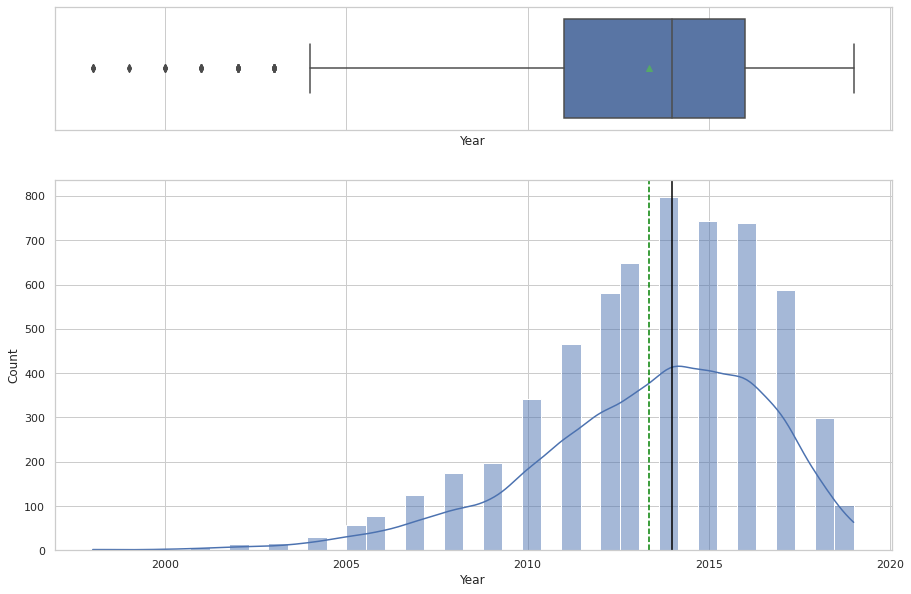

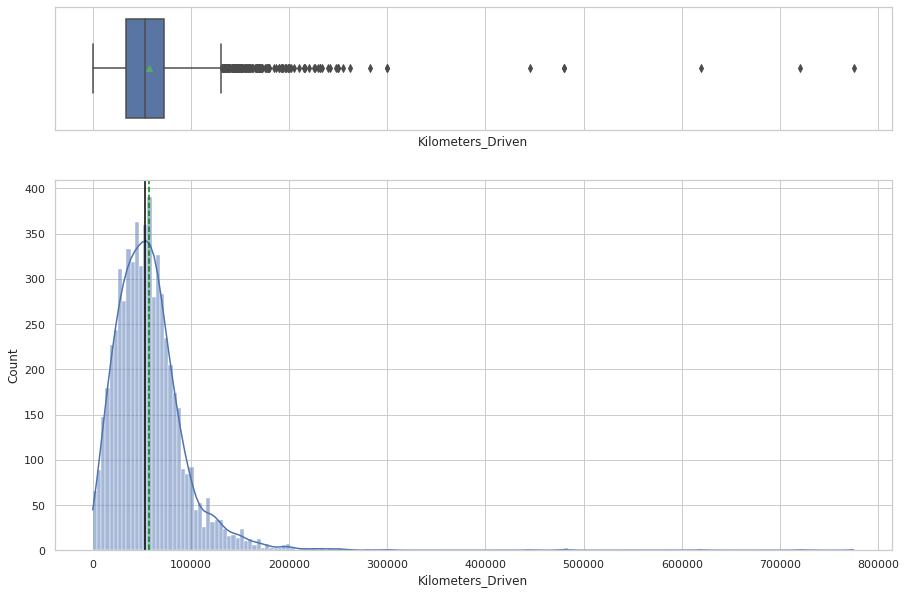

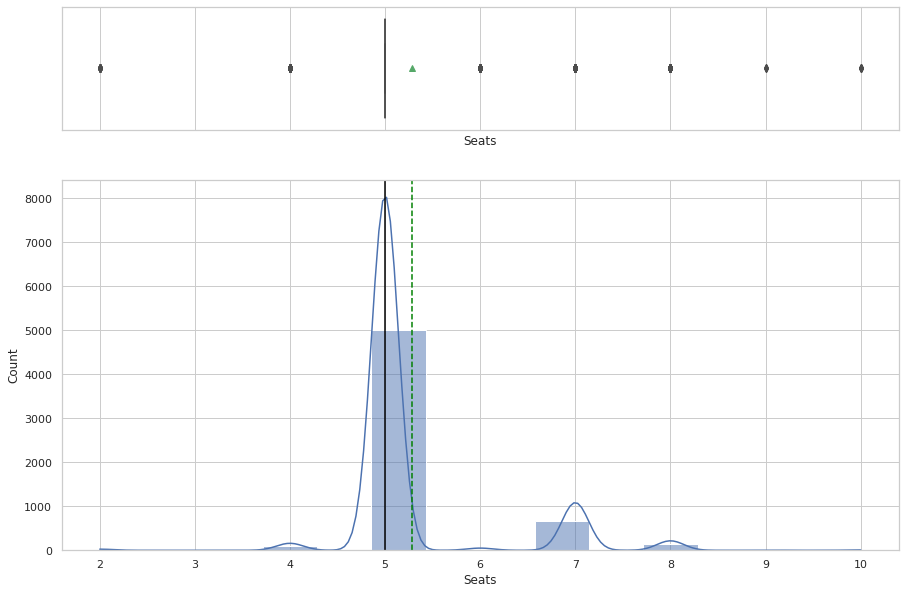

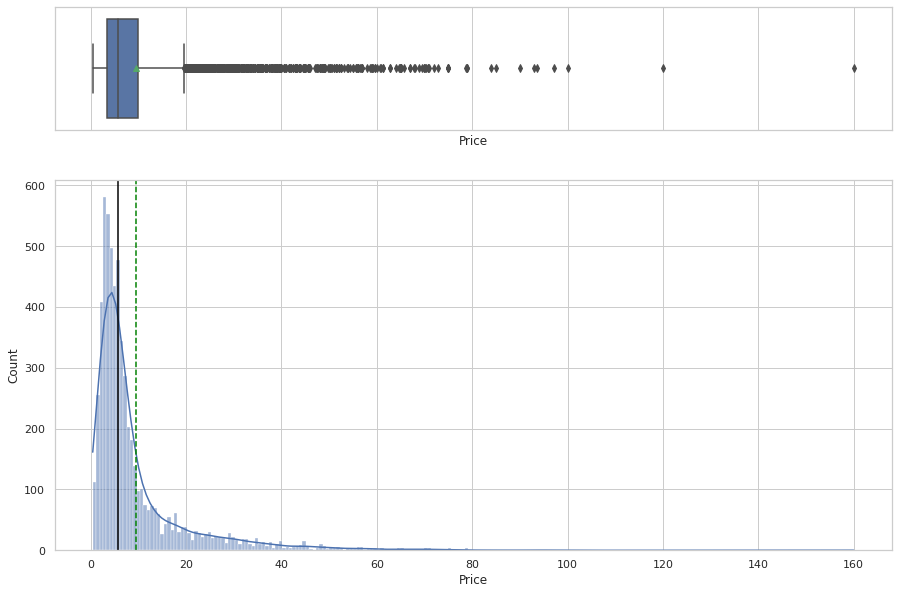

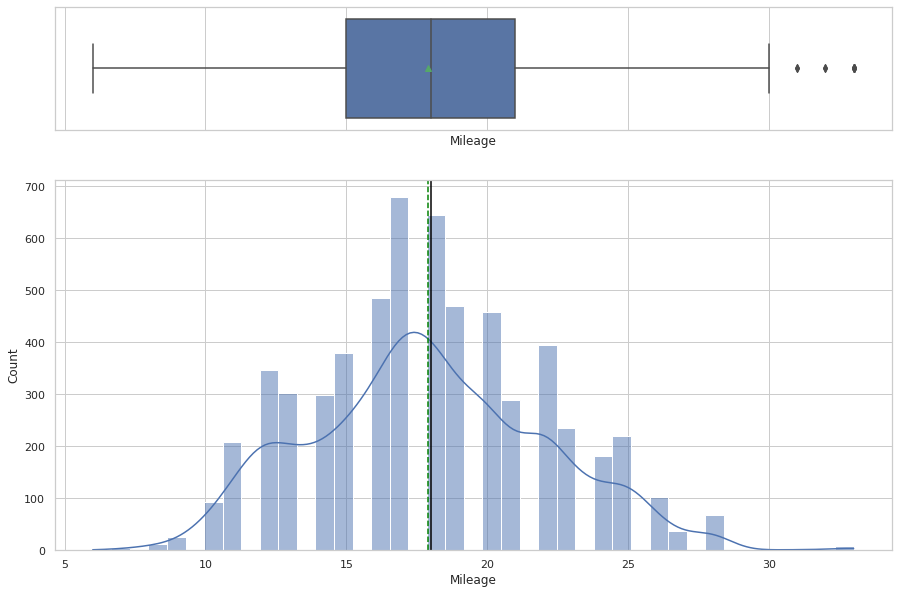

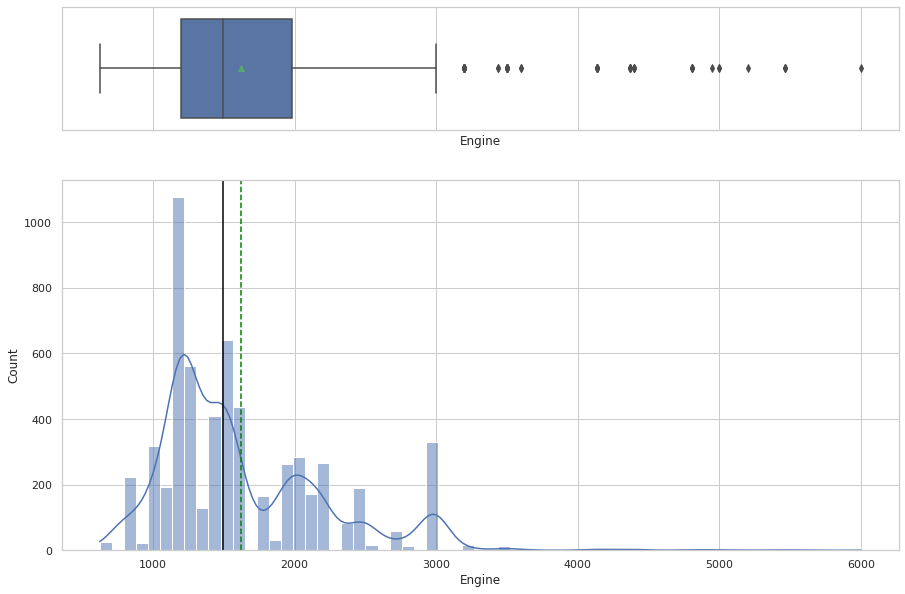

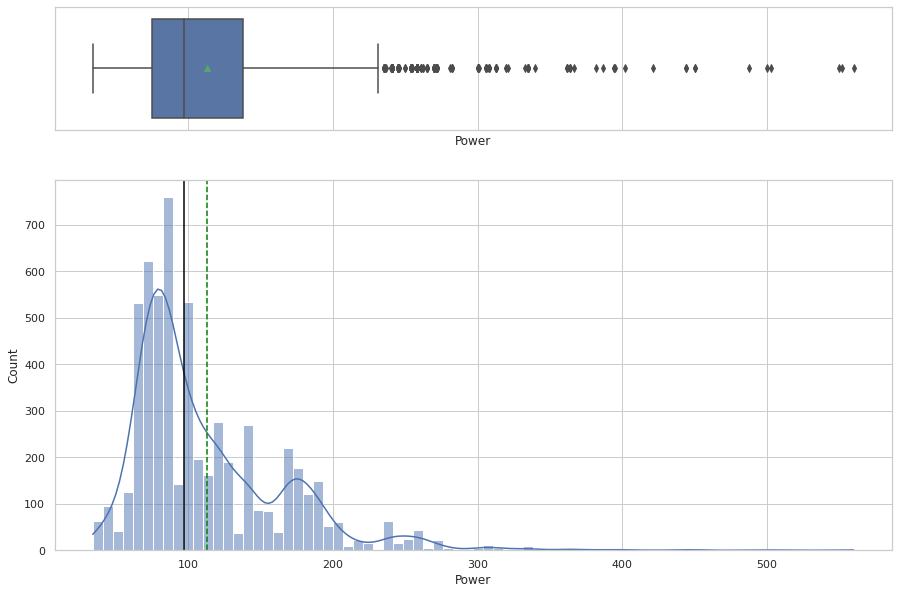

In [65]:
# Boxplot and Histplot of columns
for column in [column[0] for column in used_cars_df.dtypes if column[1] != 'string']:
    boxplot_histogram(used_cars_df, column)

**Year**

**Observations**
 - `Price` is a very skewed distribution
 - Look at log transformation

**Kilometers_Driven**

**Observations**
 - `Kilometers_Driven` is a skewed distribution
 - Look at log transformation

**Seats**

**Observations**
 - `Seats` should be analyzed as a category

**Price**

**Observations**
 - `Price` is a very skewed distribution
 - Look at log transformation

**Mileage**

**Observations**
 - `Mileage` doesnt seem skewed

**Engine**

**Observations**
 - `Engine` seems to have several distributions

**Power**

**Observations**
 - `Kilometers_Driven` is a skewed distribution
 - Look at log transformation

**Kilometers_Driven_ln**

In [66]:
from pyspark.sql.functions import log

# Add Natural Log of Kilometers_Driven Column
used_cars_df = used_cars_df.withColumn("Kilometers_Driven_ln", log("Kilometers_Driven"))

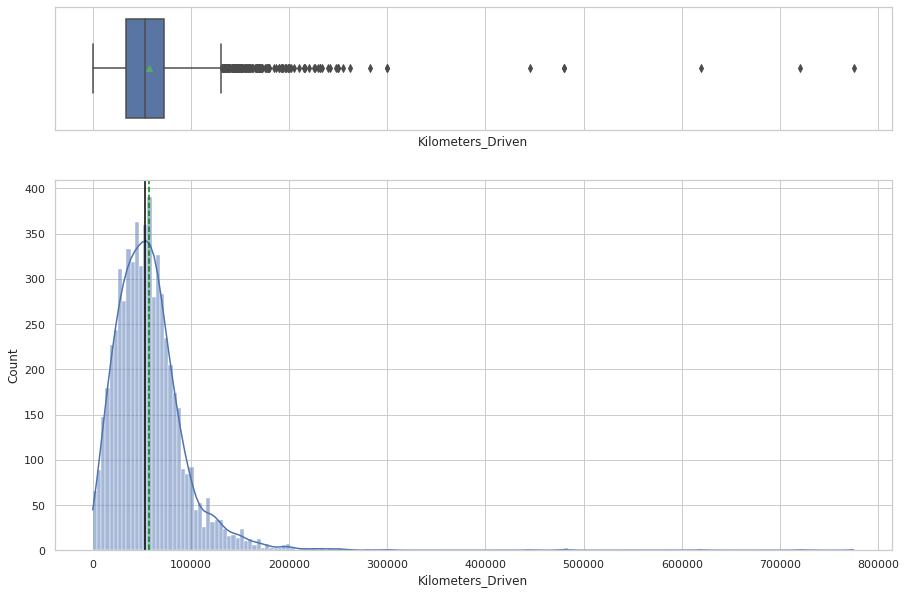

In [67]:
# Boxplot and Histplot of Kilometers_Driven
boxplot_histogram(used_cars_df, 'Kilometers_Driven')

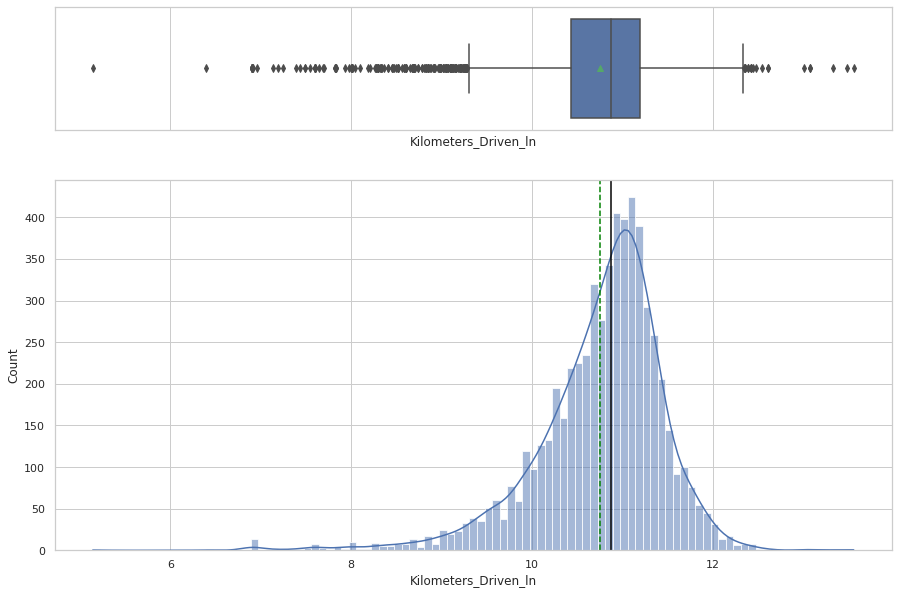

In [68]:
# Boxplot and Histplot of Kilometers_Driven_ln
boxplot_histogram(used_cars_df, 'Kilometers_Driven_ln')

**Observations**
 - Taking the Natural Log of `Kilometers_Driven` reduced the skew

**Price_ln**

In [69]:
# Add Natural Log of Price Column
used_cars_df = used_cars_df.withColumn("Price_ln", log("Price"))

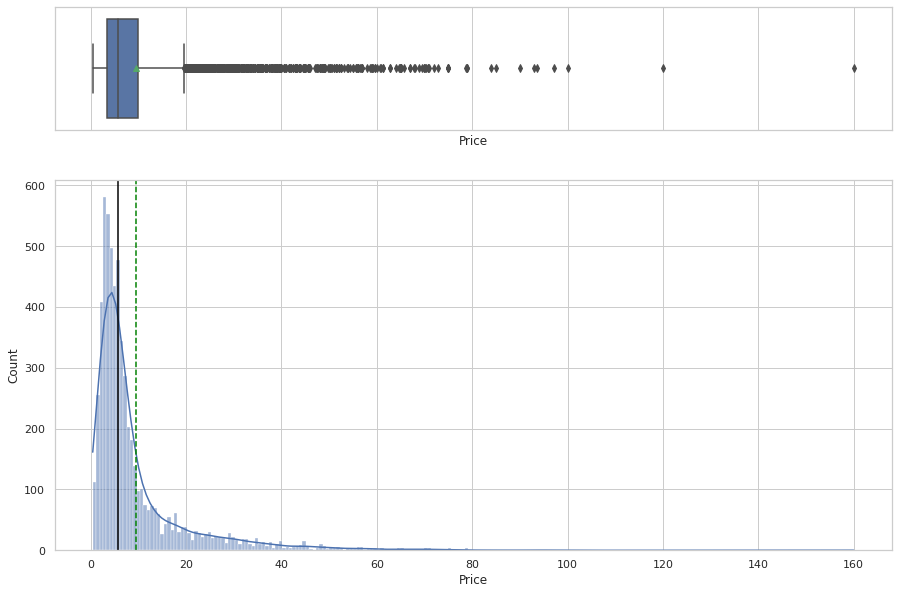

In [70]:
# Boxplot and Histplot of Price
boxplot_histogram(used_cars_df, 'Price')

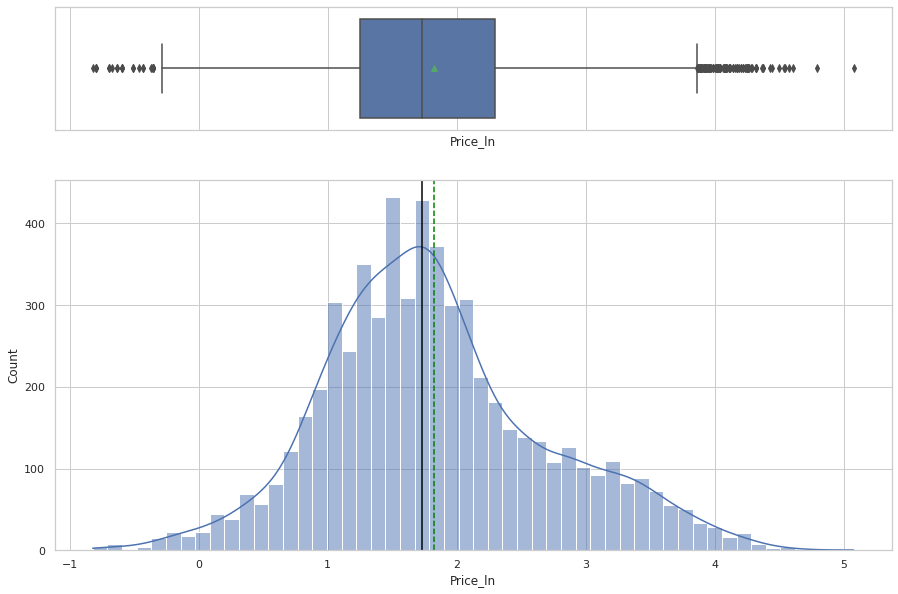

In [71]:
# Boxplot and Histplot of Price_ln
boxplot_histogram(used_cars_df, 'Price_ln')

**Observations**
 - Taking the Natural Log of `Price` really reduced the skew

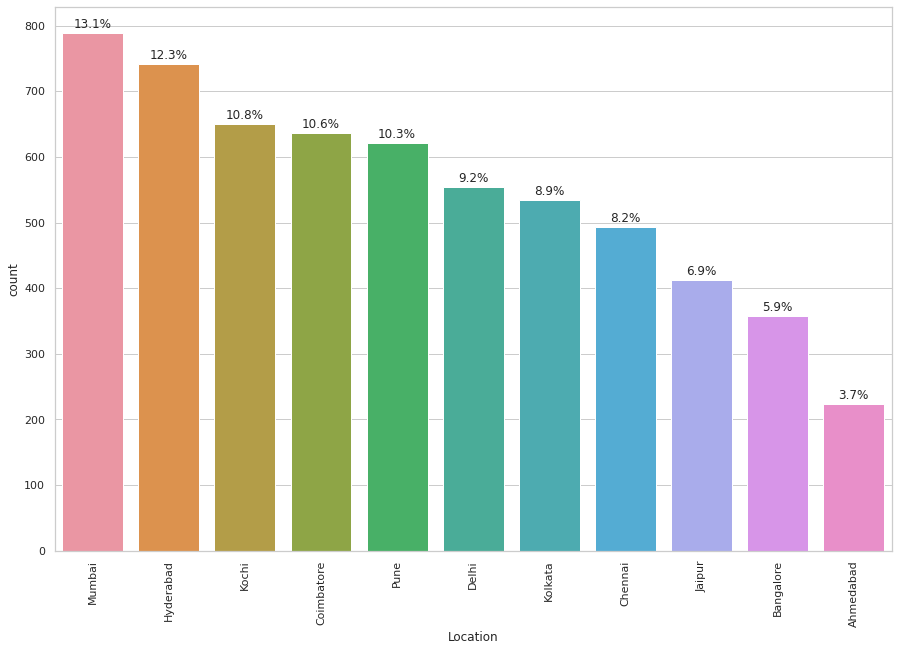

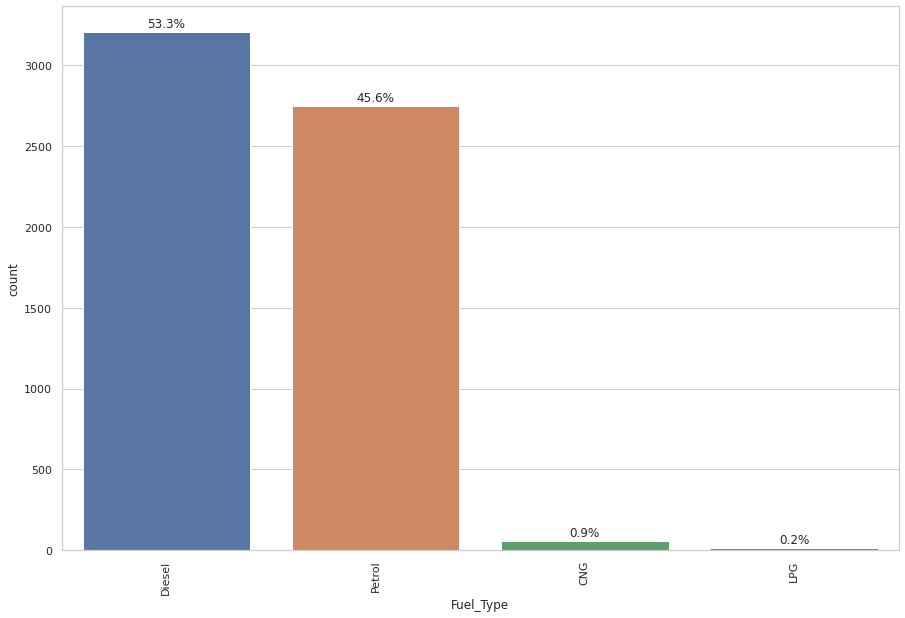

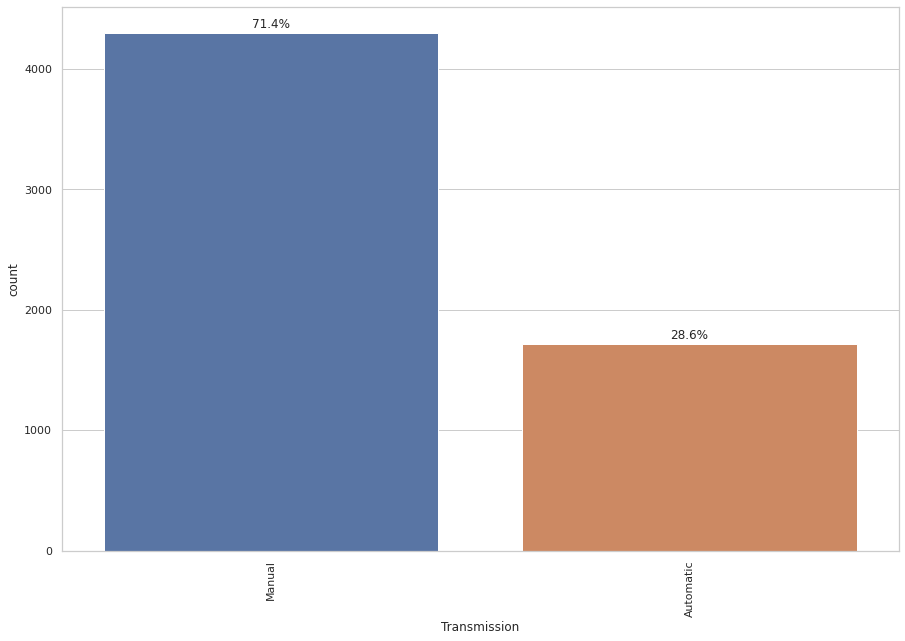

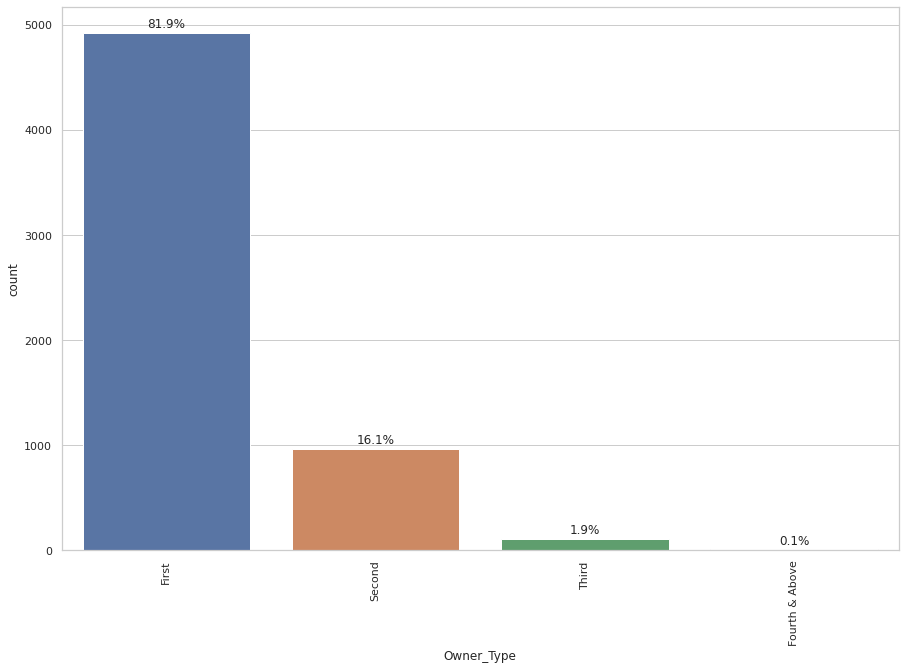

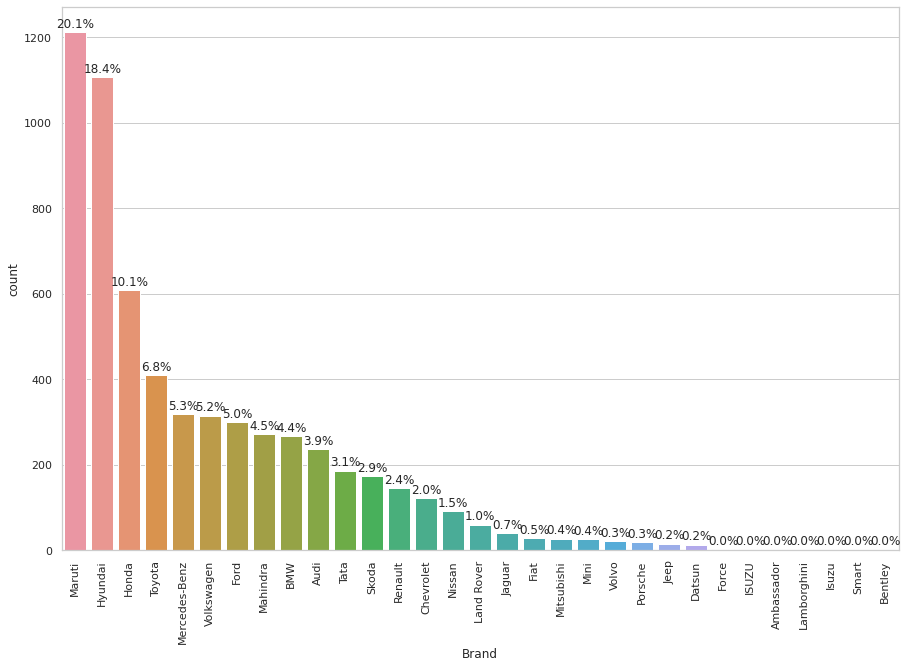

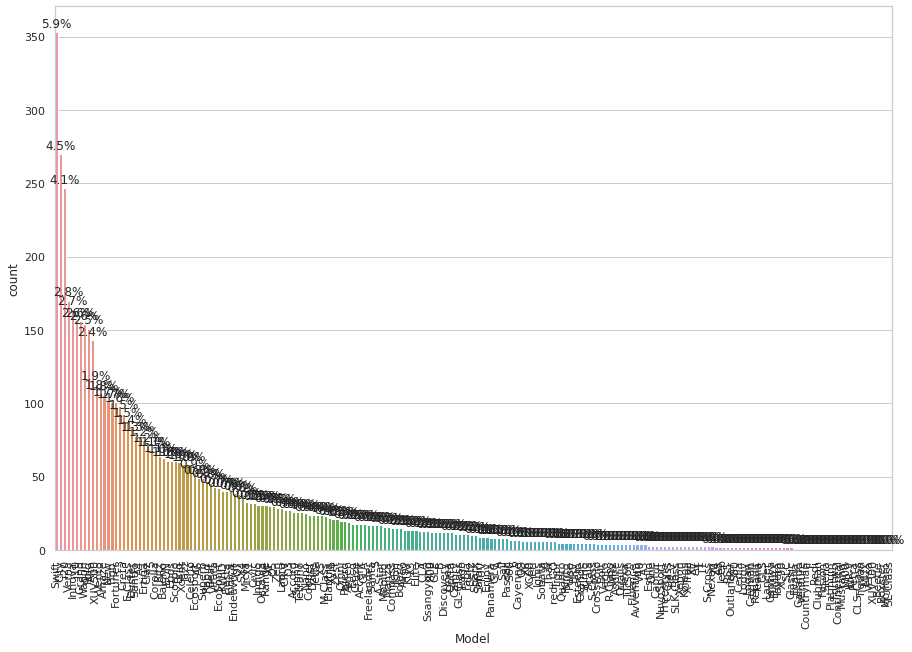

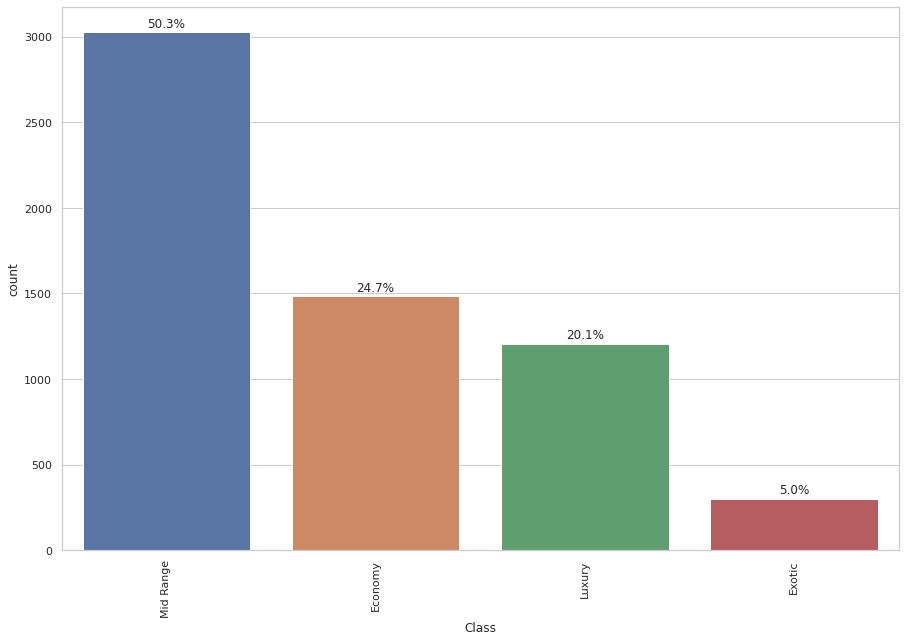

In [72]:
# Barplot of columns
for column in [column[0] for column in used_cars_df.dtypes if column[1] == 'string']:
    percent_barplot(used_cars_df, column)

**Location**

**Observations**
 - Most used cares are sold in Mumbai

**Fuel_Type**

**Observations**
 - Diesel is slightly more popular the petrol

**Transmission**

**Observations**
 - Manual used cares are more common

**Owner_Type**

**Observations**
 - Most cars had one previous owner before

**Brand**

**Observations**
 - Maruti and Hyundai make up almost 40% of the cars sold

**Model**

**Observations**
 - Maruti Swift is the most common car sold

**Class**

**Observations**
 - Sells to a variety of customers 

**Seats**

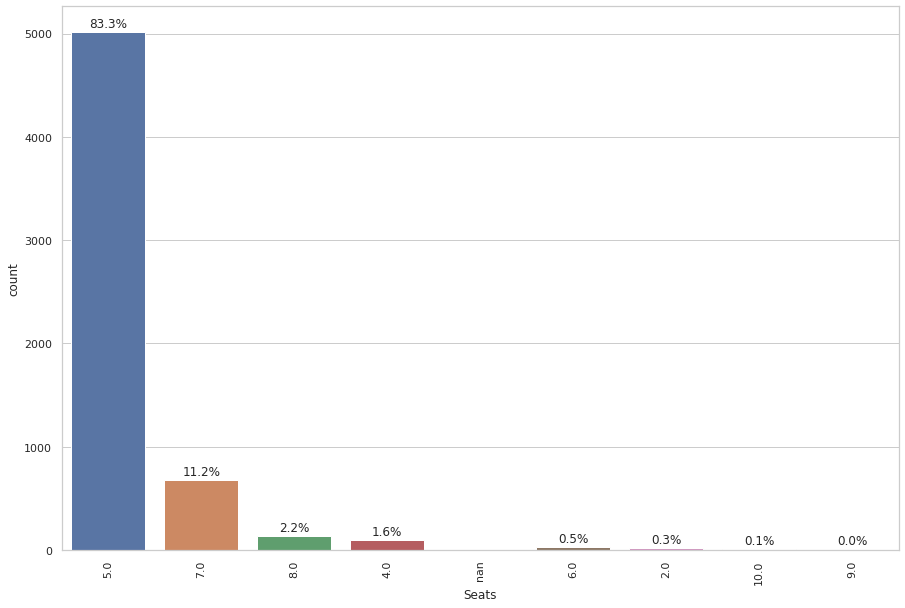

In [73]:
# Barplot of Seats
percent_barplot(used_cars_df, 'Seats')

**Observations**
 - Most cars have 5 seats

### Bivariate Distributions

In [74]:
import pandas as pd

# Create empty dataframe
corr_df = pd.DataFrame()

# for loop to create correlation martix from spark to pandas
for col1 in [col[0] for col in used_cars_df.dtypes if col[1] != 'string']:
    
    # empty row
    corr_list = []
    
    # for loop for row
    for col2 in [col[0] for col in used_cars_df.dtypes if col[1] != 'string']:
        
        # Add correlation to list
        corr_list.append(used_cars_df.stat.corr(col1, col2))

    # Add list as column
    corr_df[col1] = corr_list

# Set index name
corr_df.index = [col[0] for col in used_cars_df.dtypes if col[1] != 'string']

**Correlation Matrix**

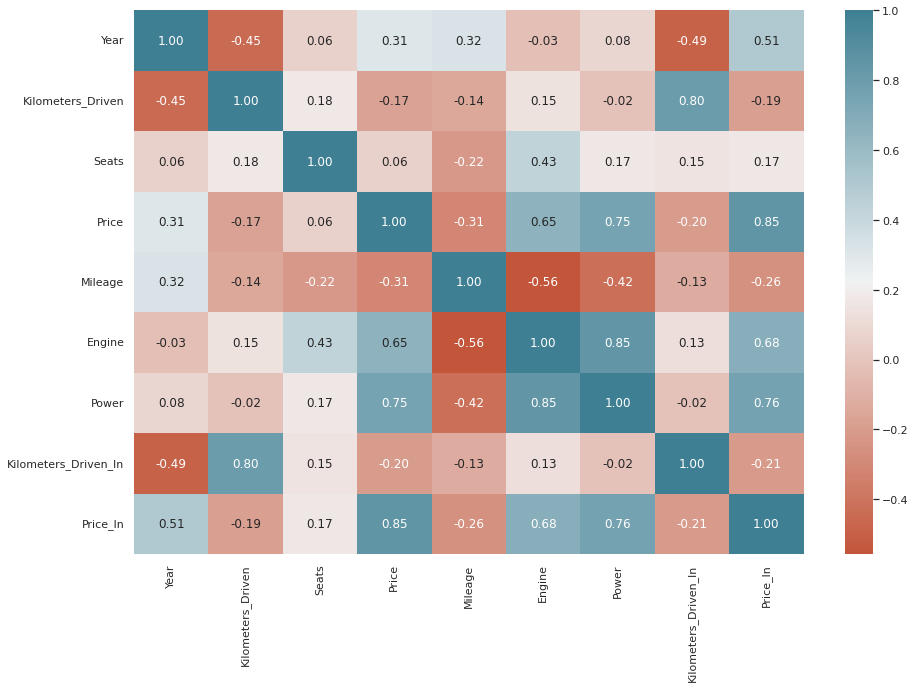

In [75]:
# Figure Size
plt.figure(figsize=(15, 10))

# Rotate x-axis labels
plt.xticks(rotation=90)

# Correlation Matrix
sns.heatmap(corr_df, annot=True, fmt = '.2f', cmap = sns.diverging_palette(20, 220, as_cmap=True))

# Show plot
plt.show()

**Observations**
 - `Power` and `Engine` are highly correlated with price
 - `Power` and `Engine` are highly correlated with each other with potential multicollinearity

**Pairplot**

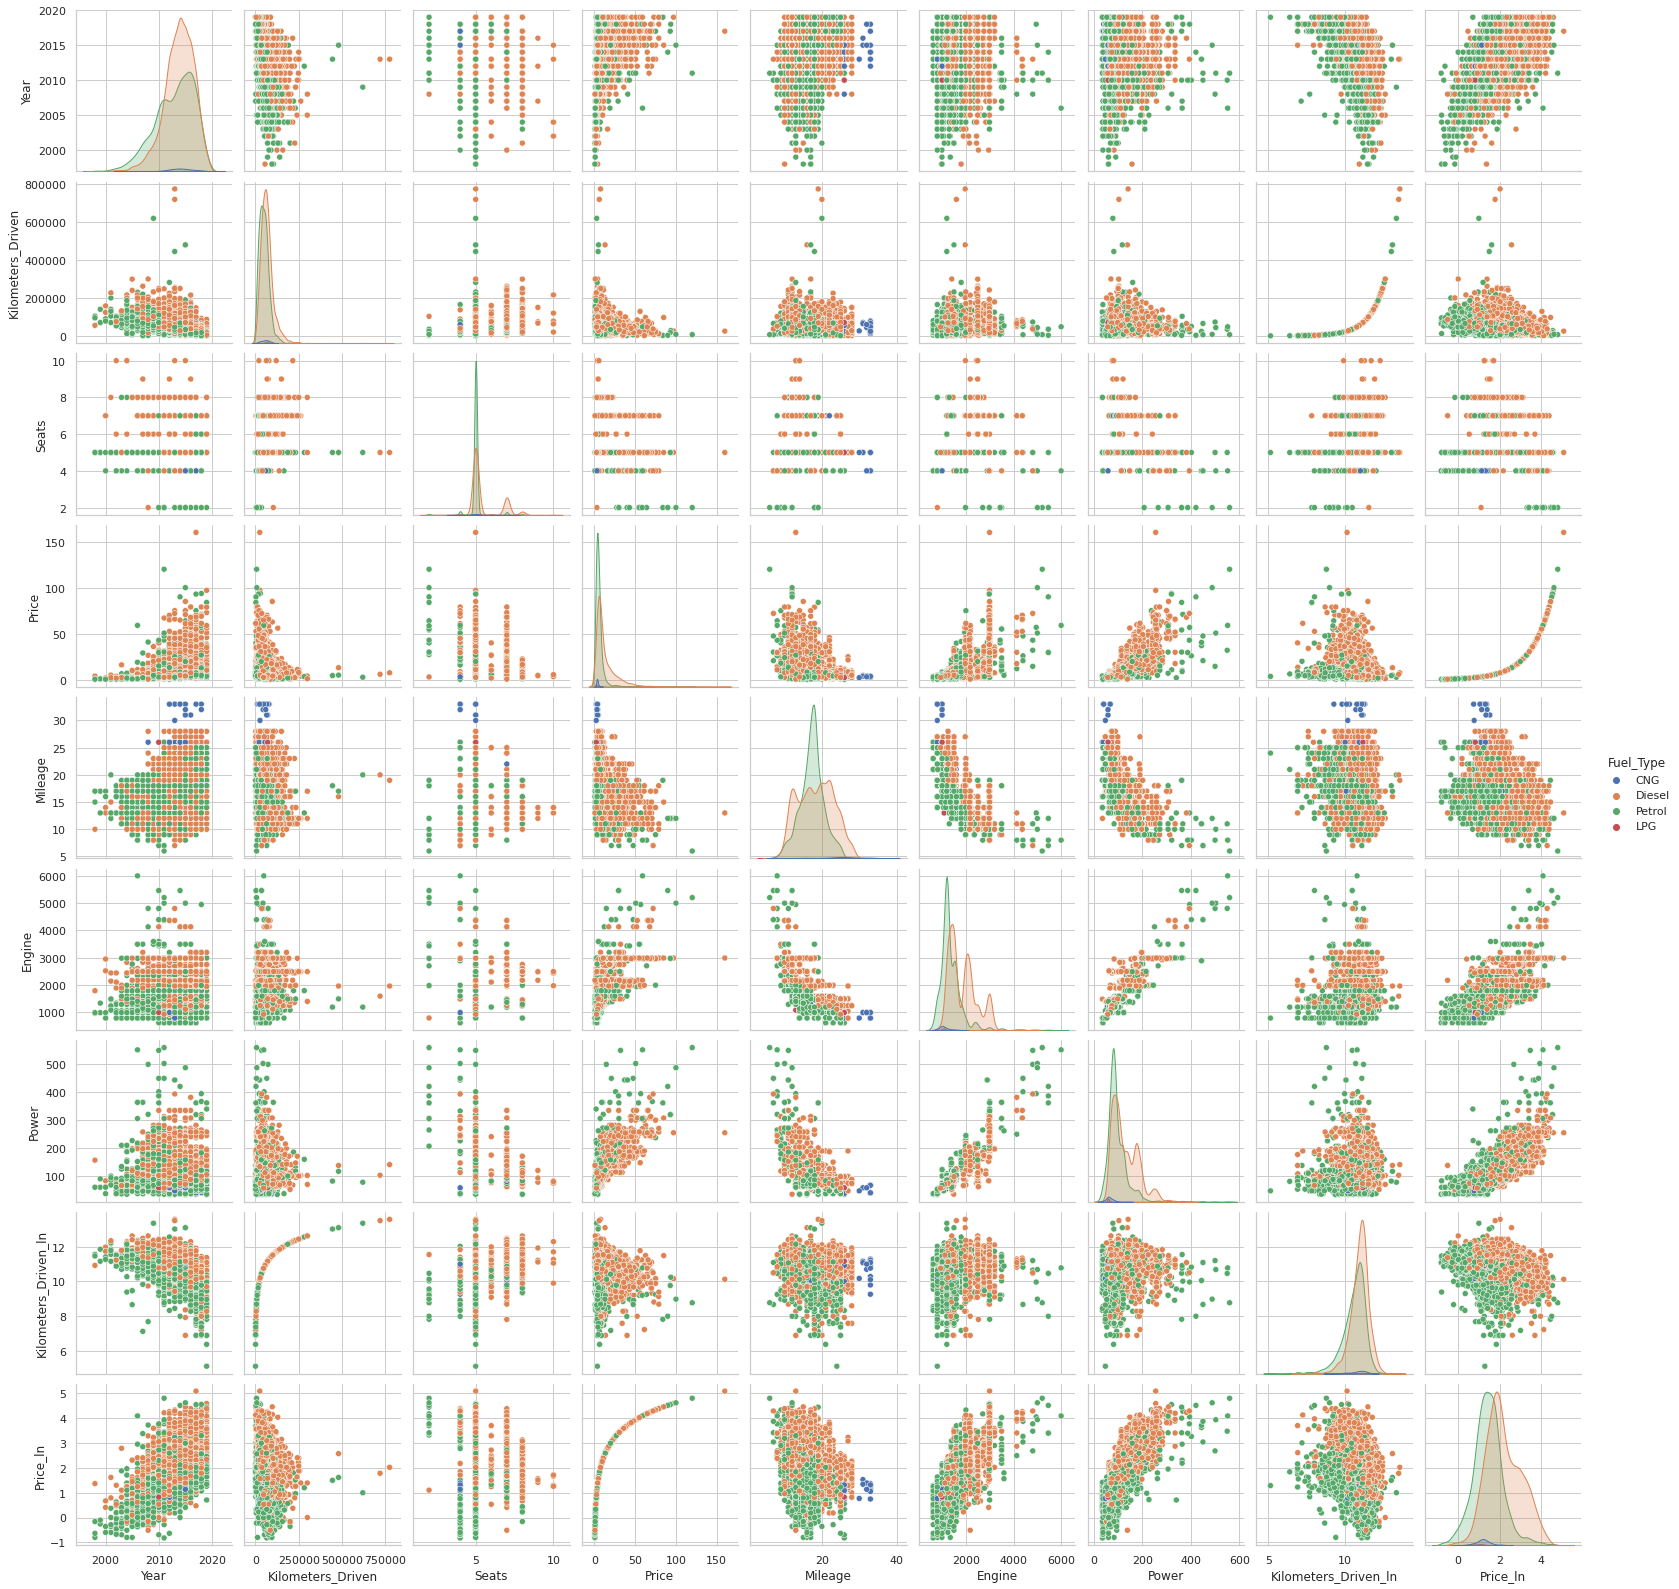

In [76]:
# Pairplot
sns.pairplot(data=used_cars_df.toPandas(),hue="Fuel_Type", diag_kind="kde")
plt.show()

**Observations**
 - Petrol has better `mileage`
 - for 2 `seaters` they seem to be mostly petrol
 -  more then 5 seats seem to be diesel

**Price vs Location**

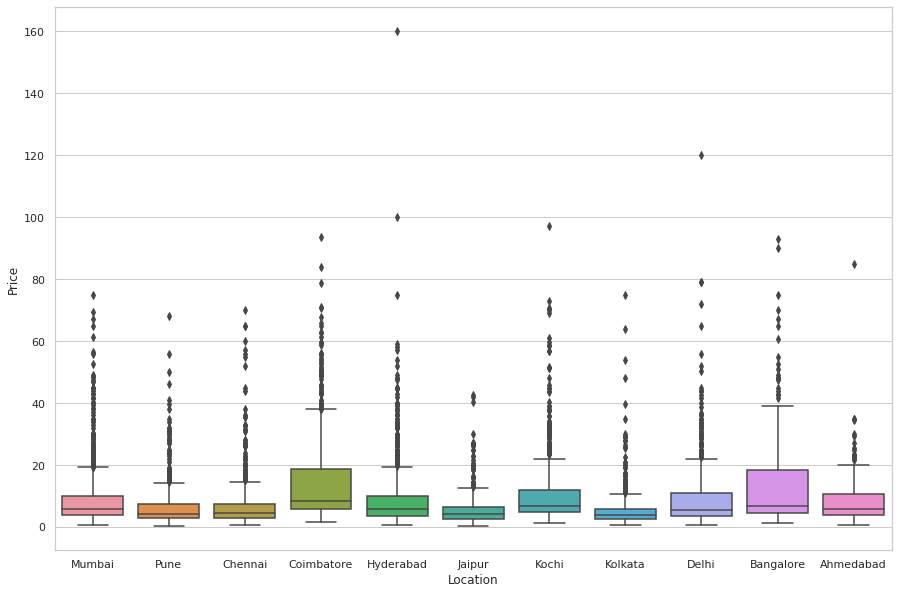

In [77]:
# Boxplot
plt.figure(figsize=(15, 10))
sns.boxplot(x = used_cars_df.select('Location').toPandas()['Location'],
            y = used_cars_df.select('Price').toPandas()['Price'])
plt.show()

**Observations**
 - Coimbateore and Bangalore have more expensive used car prices

**Price vs Transmission**

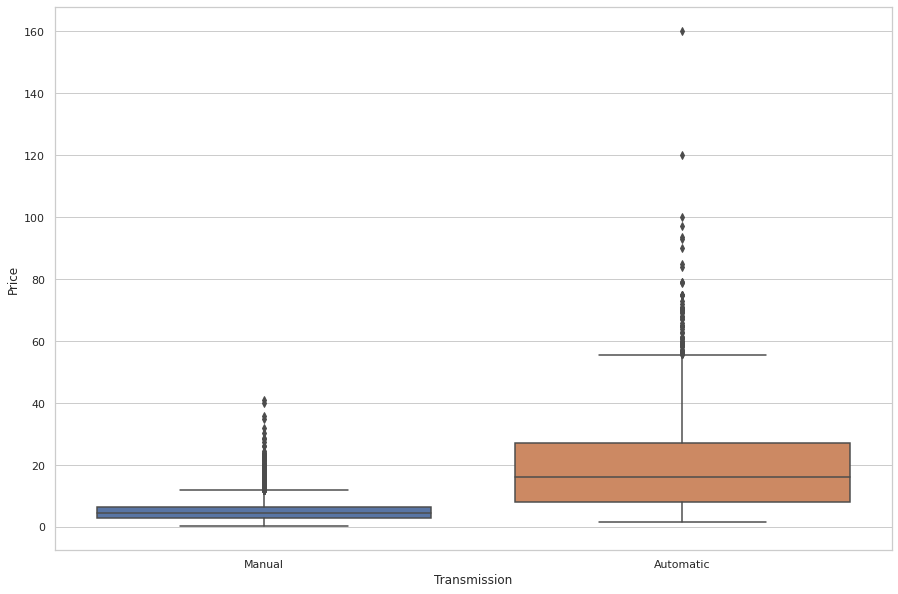

In [78]:
# Boxplot
plt.figure(figsize=(15, 10))
sns.boxplot(x = used_cars_df.select('Transmission').toPandas()['Transmission'],
            y = used_cars_df.select('Price').toPandas()['Price'])
plt.show()

**Observations**
 - Automatic used cars cost more

**Price vs Year**

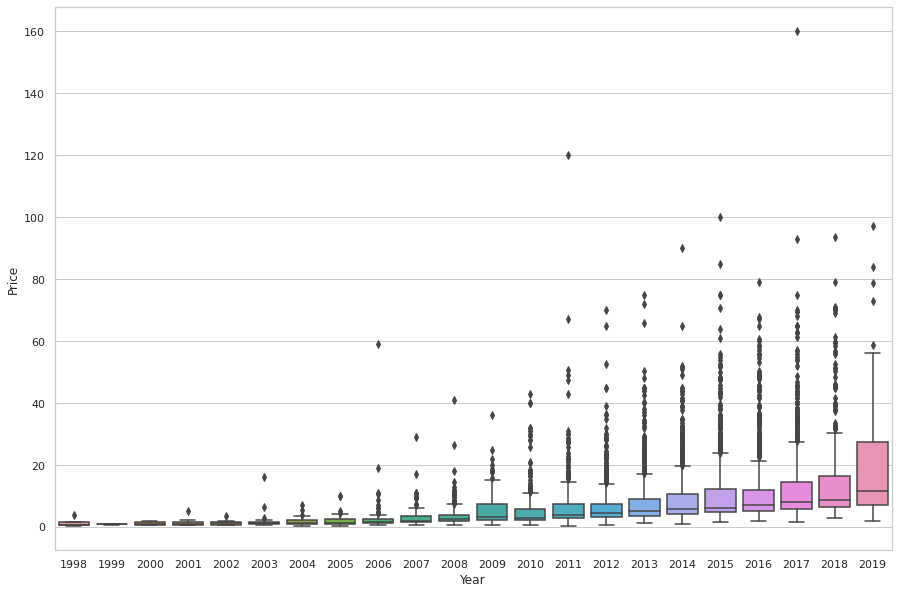

In [79]:
# Boxplot
plt.figure(figsize=(15, 10))
sns.boxplot(x = used_cars_df.select('Year').toPandas()['Year'],
            y = used_cars_df.select('Price').toPandas()['Price'])
plt.show()

**Observations**
 - Newer used cars cost more
 - 2009 seems to slightly break that trend

In [80]:
# Drop Kilometers_Driven column
used_cars_df = used_cars_df.drop('Kilometers_Driven')

# Drop Price_ln column
used_cars_df = used_cars_df.drop('Price_ln')

### Missing Values

In [81]:
# For loop to display null values in Spark Dataframe
print('     Number of Null Values in Columns')
for col in used_cars_df.columns:
    if used_cars_df[used_cars_df[col].isNull()].count() > 0:
        print(f'{col}:')
        print(used_cars_df[used_cars_df[col].isNull()].count())

     Number of Null Values in Columns
Seats:
42
Mileage:
68
Engine:
36
Power:
143
Kilometers_Driven_ln:
1


**Seats**
 - Check dataset to see if missing values are already in the dataset

In [82]:
# Display cars with missing Seats
used_cars_df[used_cars_df['Seats'].isNull()].show()

+----------+----+---------+------------+----------+-----+-----+-------+------+-----+----------+------+---------+--------------------+
|  Location|Year|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|     Brand| Model|    Class|Kilometers_Driven_ln|
+----------+----+---------+------------+----------+-----+-----+-------+------+-----+----------+------+---------+--------------------+
| Ahmedabad|2007|   Petrol|      Manual|     First| null| 2.95|   null|  null| null|     Honda|  City|  Economy|  11.002199836204571|
|   Kolkata|2010|   Petrol|      Manual|     First| null| 2.11|     16|  null| null|    Maruti| Swift|  Economy|  10.645448706505872|
| Bangalore|2015|   Diesel|      Manual|     First| null|  3.6|   null|  1498|   99|      Ford|  Figo|Mid Range|  11.162459775080668|
|   Chennai|2006|   Petrol|      Manual|     Third| null| 1.75|     16|  null| null|    Maruti| Swift|  Economy|   11.49067985602291|
|    Mumbai|2008|   Diesel|   Automatic|    Second| null| 26.5

In [83]:
# Get median values of Seats for model in dataframe
model_seat_df = used_cars_df.groupBy('Model').agg(f.expr('percentile(Seats, array(0.50))')[0].alias("median_model_seat")).withColumnRenamed("Model", "Model_drop")

In [84]:
# Add median column for seats to fill in null values
used_cars_df = used_cars_df.join(model_seat_df,used_cars_df.Model == model_seat_df.Model_drop,"outer")

In [85]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Seats", when(used_cars_df.Seats.isNull() ,used_cars_df.median_model_seat)
                                 .otherwise(used_cars_df.Seats))

In [86]:
# Drop median_model_seat column
used_cars_df = used_cars_df.drop('median_model_seat')

# Drop Model_drop column
used_cars_df = used_cars_df.drop('Model_drop')

In [87]:
# Dsiplay Seats
used_cars_df.groupBy('Seats').count().show()

+-----+-----+
|Seats|count|
+-----+-----+
|  8.0|  134|
|  7.0|  675|
| null|    3|
|  4.0|   99|
|  2.0|   16|
| 10.0|    5|
|  6.0|   31|
|  5.0| 5051|
|  9.0|    3|
+-----+-----+



In [88]:
# Display cars with missing Seats
used_cars_df[used_cars_df['Seats'].isNull()].show()

+--------+----+---------+------------+----------+-----+-----+-------+------+-----+------+------+-------+--------------------+
|Location|Year|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power| Brand| Model|  Class|Kilometers_Driven_ln|
+--------+----+---------+------------+----------+-----+-----+-------+------+-----+------+------+-------+--------------------+
| Chennai|2008|   Petrol|      Manual|    Second| null|  1.5|     19|  1061| null|Maruti|Estilo|Economy|  10.933106969717286|
| Kolkata|2010|   Petrol|      Manual|    Second| null|  2.5|     19|  1061| null|Maruti|Estilo|Economy|  10.596634733096073|
| Chennai|2008|   Petrol|      Manual|    Second| null| 1.75|     19|  1061| null|Maruti|Estilo|Economy|  10.839580911706463|
+--------+----+---------+------------+----------+-----+-----+-------+------+-----+------+------+-------+--------------------+



**Observations**
 - Taking existing `Seats` from dataset filled all (42) null values except 3 all from the same model
 - Fill in missing data from looking up manually

In [89]:
# Fill in missing seat data manually
used_cars_df = used_cars_df.withColumn("Seats", when(used_cars_df.Seats.isNull() ,5)
                                 .otherwise(used_cars_df.Seats))

**Mileage**
 - Replace null values with median of `Year` and `Model`

In [90]:
# Display cars with missing Mileage
used_cars_df[used_cars_df['Mileage'].isNull()].show()

+----------+----+---------+------------+----------+-----+-----+-------+------+-----+-------------+----------+---------+--------------------+
|  Location|Year|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|        Brand|     Model|    Class|Kilometers_Driven_ln|
+----------+----+---------+------------+----------+-----+-----+-------+------+-----+-------------+----------+---------+--------------------+
| Bangalore|2015|   Diesel|      Manual|     First|  5.0|  3.6|   null|  1498|   99|         Ford|      Figo|Mid Range|  11.162459775080668|
|      Pune|2012|   Diesel|   Automatic|    Second|  5.0| 17.5|   null|  2179|  115|   Land Rover|Freelander|   Luxury|  11.350406535472453|
| Bangalore|2010|   Diesel|   Automatic|    Second|  5.0| 11.0|   null|  2179|  115|   Land Rover|Freelander|   Luxury|  11.736069016284437|
|    Jaipur|2012|   Diesel|   Automatic|     First|  5.0| 16.5|   null|  2179|  115|   Land Rover|Freelander|   Luxury|  11.688583201081919|
|     Delhi|2

In [91]:
# Display cars with missing Mileage
used_cars_df[used_cars_df['Mileage'].isNull()].groupBy('Year','Model').count().show(40)

+----+----------+-----+
|Year|     Model|count|
+----+----------+-----+
|2008|    Fortwo|    1|
|2019|       New|    1|
|2018|   C-Class|    1|
|2010|    Superb|    1|
|2012|        A7|    1|
|2019|   C-Class|    2|
|2010|     Jetta|    1|
|2007|      City|    1|
|2008|     Range|    2|
|2008|    Santro|    4|
|2002|      Jeep|    1|
|2007|    Santro|    3|
|2001|    Qualis|    1|
|2003|     Range|    1|
|2002|      City|    1|
|2006|    Santro|    4|
|2009|    Superb|    1|
|2004|    Santro|    3|
|2009|    Santro|    3|
|2010|Freelander|    1|
|2009|      Jeep|    1|
|2002|    Santro|    2|
|2014|   M-Class|    2|
|2012|    Santro|    5|
|2015|      Figo|    1|
|2001|     Siena|    1|
|2012|   M-Class|    2|
|2005|    Santro|    4|
|2015|   M-Class|    2|
|2004|      City|    1|
|2016|   M-Class|    2|
|2010|    Santro|    1|
|2013|Freelander|    2|
|2004|    Qualis|    1|
|2011|    Santro|    3|
|2012|Freelander|    3|
|2005|    Baleno|    1|
+----+----------+-----+



In [92]:
from pyspark.sql.functions import col

# Concat year and model for join
used_cars_df = used_cars_df.withColumn('Year_Model', concat_ws('', col('Year'), col('Model')))

In [93]:
from pyspark.sql.functions import concat,concat_ws

# Get median values of Mileage for model in dataframe
model_mileage_df = used_cars_df.groupBy('Year','Model').agg(f.expr('percentile(Mileage, array(0.50))')[0]
                                         .alias("median_year_model_Mileage")) \
.withColumnRenamed("Model", "Model_drop") \
.withColumnRenamed("Year", "Year_drop") \
.withColumn('Year_Model_drop', concat_ws('', col('Year_drop'), col('Model_drop')))

# Drop Model_drop column
model_mileage_df = model_mileage_df.drop('Model_drop')

# Drop Year_drop column
model_mileage_df = model_mileage_df.drop('Year_drop')

In [94]:
# Add median column for Mileage to fill in null values
used_cars_df = used_cars_df.join(model_mileage_df,used_cars_df.Year_Model == model_mileage_df.Year_Model_drop,"outer")

In [95]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Mileage", when(used_cars_df.Mileage.isNull() ,used_cars_df.median_year_model_Mileage)
                                 .otherwise(used_cars_df.Mileage))

In [96]:
# Drop median_model_Mileage column
used_cars_df = used_cars_df.drop('median_year_model_Mileage')

# Drop Model_drop column
used_cars_df = used_cars_df.drop('Year_Model_drop')

# Drop Year_Model column
used_cars_df = used_cars_df.drop('Year_Model')

In [97]:
# Display cars with missing Mileage
used_cars_df[used_cars_df['Mileage'].isNull()].show()

+----------+----+---------+------------+--------------+-----+-----+-------+------+-----+-------------+----------+---------+--------------------+
|  Location|Year|Fuel_Type|Transmission|    Owner_Type|Seats|Price|Mileage|Engine|Power|        Brand|     Model|    Class|Kilometers_Driven_ln|
+----------+----+---------+------------+--------------+-----+-----+-------+------+-----+-------------+----------+---------+--------------------+
|    Mumbai|2003|   Diesel|   Automatic|        Second|  5.0|16.11|   null|  null| null|   Land Rover|     Range|   Luxury|  11.225243392518447|
|    Mumbai|2018|   Diesel|   Automatic|         First|  5.0| 39.5|   null|  1950|  194|Mercedes-Benz|   C-Class|   Exotic|    9.06900719585954|
|Coimbatore|2019|   Diesel|   Automatic|         First|  5.0|35.67|   null|  1950|  194|Mercedes-Benz|   C-Class|   Exotic|   9.640107772607312|
| Ahmedabad|2019|   Diesel|   Automatic|         First|  5.0| 35.0|   null|  1950|  194|Mercedes-Benz|   C-Class|   Exotic|   8.29

In [98]:
# Display cars with missing Mileage
used_cars_df[used_cars_df['Mileage'].isNull()].groupBy('Year','Model').count().show(50)

+----+----------+-----+
|Year|     Model|count|
+----+----------+-----+
|2008|    Fortwo|    1|
|2018|   C-Class|    1|
|2012|        A7|    1|
|2019|   C-Class|    2|
|2010|     Jetta|    1|
|2008|     Range|    2|
|2002|      Jeep|    1|
|2001|    Qualis|    1|
|2003|     Range|    1|
|2004|    Santro|    3|
|2009|      Jeep|    1|
|2010|Freelander|    1|
|2002|    Santro|    2|
|2001|     Siena|    1|
+----+----------+-----+



In [99]:
# Display null values in Spark Dataframe for Mileage
print('     Number of Null Values in Mileage')
print(used_cars_df[used_cars_df['Mileage'].isNull()].count())

     Number of Null Values in Mileage


19


**Observations**
 - Median `Mileage` from `Year` and `Model` took null values from 68 to 19
 - Fill in missing data by using median for `Year`

In [100]:
# Get median values of Mileage for Year in dataframe
year_mileage_df = used_cars_df.groupBy('Year').agg(f.expr('percentile(Mileage, array(0.50))')[0].alias("median_year_mileage")).withColumnRenamed("Year", "Year_drop")

In [101]:
# Add median column for Mileage for Year to fill in null values
used_cars_df = used_cars_df.join(year_mileage_df,used_cars_df.Year == year_mileage_df.Year_drop,"outer")

In [102]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Mileage", when(used_cars_df.Mileage.isNull() ,used_cars_df.median_year_mileage)
                                 .otherwise(used_cars_df.Mileage))

In [103]:
# Drop median_model_Mileage column
used_cars_df = used_cars_df.drop('median_year_mileage')

# Drop Model_drop column
used_cars_df = used_cars_df.drop('Year_drop')

In [104]:
# Display null values in Spark Dataframe for Mileage
print('     Number of Null Values in Mileage')
print(used_cars_df[used_cars_df['Mileage'].isNull()].count())

     Number of Null Values in Mileage


0


**Engine**
 - Replace null values with median of `Year` and `Model`

In [105]:
# Display cars with missing Engine
used_cars_df[used_cars_df['Engine'].isNull()].show()

+----------+----+---------+------------+--------------+-----+-----+-------+------+-----+----------+------+---------+--------------------+
|  Location|Year|Fuel_Type|Transmission|    Owner_Type|Seats|Price|Mileage|Engine|Power|     Brand| Model|    Class|Kilometers_Driven_ln|
+----------+----+---------+------------+--------------+-----+-----+-------+------+-----+----------+------+---------+--------------------+
|    Mumbai|2003|   Diesel|   Automatic|        Second|  5.0|16.11|   15.5|  null| null|Land Rover| Range|   Luxury|  11.225243392518447|
|      Pune|2003|   Petrol|      Manual|        Second|  5.0|  0.9|   17.0|  null| null|   Hyundai|Santro|  Economy|  11.289781913656018|
| Ahmedabad|2007|   Petrol|      Manual|         First|  5.0| 2.95|   16.0|  null| null|     Honda|  City|  Economy|  11.002199836204571|
|    Mumbai|2007|   Petrol|      Manual|        Second|  5.0| 1.75|   16.0|  null| null|    Maruti| Swift|  Economy|  10.915088464214607|
| Hyderabad|2015|   Petrol|      M

In [106]:
# Display cars with missing Engine
used_cars_df[used_cars_df['Engine'].isNull()].groupBy('Year','Model').count().show(40)

+----+------+-----+
|Year| Model|count|
+----+------+-----+
|2015| Swift|    2|
|2012| Swift|    1|
|2014| Swift|    1|
|2011| Swift|    1|
|2007|  City|    1|
|2008| Range|    2|
|2008|     5|    1|
|2003|Santro|    1|
|2012| Etios|    1|
|2003| Range|    1|
|2002|  City|    1|
|2004|Santro|    1|
|2014|     5|    1|
|2009|Santro|    1|
|2006| Swift|    3|
|2013|  CR-V|    1|
|2007| Swift|    1|
|2012|Santro|    2|
|2012|     5|    3|
|2011| Punto|    1|
|2005|Santro|    1|
|2004|  City|    1|
|2001| Wagon|    1|
|2009|  City|    1|
|2011|Santro|    1|
|2017| Punto|    1|
|2010| Punto|    1|
|2011|  Jazz|    1|
|2010| Swift|    1|
+----+------+-----+



In [107]:
from pyspark.sql.functions import col

# Concat year and model for join
used_cars_df = used_cars_df.withColumn('Year_Model', concat_ws('', col('Year'), col('Model')))

In [108]:
from pyspark.sql.functions import concat,concat_ws

# Get median values of Engine for model in dataframe
model_engine_df = used_cars_df.groupBy('Year','Model').agg(f.expr('percentile(Engine, array(0.50))')[0]
                                         .alias("median_year_model_engine")) \
.withColumnRenamed("Model", "Model_drop") \
.withColumnRenamed("Year", "Year_drop") \
.withColumn('Year_Model_drop', concat_ws('', col('Year_drop'), col('Model_drop')))

# Drop Model_drop column
model_engine_df = model_engine_df.drop('Model_drop')

# Drop Year_drop column
model_engine_df = model_engine_df.drop('Year_drop')

In [109]:
# Add median column for Engine to fill in null values
used_cars_df = used_cars_df.join(model_engine_df,used_cars_df.Year_Model == model_engine_df.Year_Model_drop,"outer")

In [110]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Engine", when(used_cars_df.Engine.isNull() ,used_cars_df.median_year_model_engine)
                                 .otherwise(used_cars_df.Engine))

In [111]:
# Drop median_year_model_engine column
used_cars_df = used_cars_df.drop('median_year_model_engine')

# Drop Year_Model_drop column
used_cars_df = used_cars_df.drop('Year_Model_drop')

# Drop Year_Model column
used_cars_df = used_cars_df.drop('Year_Model')

In [112]:
# Display cars with missing Engine
used_cars_df[used_cars_df['Engine'].isNull()].show()

+----------+----+---------+------------+----------+-----+-----+-------+------+-----+----------+------+---------+--------------------+
|  Location|Year|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|     Brand| Model|    Class|Kilometers_Driven_ln|
+----------+----+---------+------------+----------+-----+-----+-------+------+-----+----------+------+---------+--------------------+
|    Mumbai|2003|   Diesel|   Automatic|    Second|  5.0|16.11|   15.5|  null| null|Land Rover| Range|   Luxury|  11.225243392518447|
|      Pune|2011|   Diesel|      Manual|     First|  5.0|  2.6|   20.0|  null| null|      Fiat| Punto|  Economy|  10.720421929870149|
|    Jaipur|2001|   Petrol|      Manual|     First|  5.0|  0.7|   12.0|  null| null|    Maruti| Wagon|  Economy|  12.206072645530174|
|     Kochi|2017|   Petrol|      Manual|     First|  5.0| 3.93|   15.0|  null| null|      Fiat| Punto|Mid Range|   9.794843875419385|
|      Pune|2003|   Petrol|      Manual|    Second|  5.0|  0.9

In [113]:
# Display cars with missing Engine
used_cars_df[used_cars_df['Engine'].isNull()].groupBy('Year','Model').count().show(50)

+----+------+-----+
|Year| Model|count|
+----+------+-----+
|2008| Range|    2|
|2003|Santro|    1|
|2003| Range|    1|
|2011| Punto|    1|
|2001| Wagon|    1|
|2017| Punto|    1|
+----+------+-----+



In [114]:
# Display null values in Spark Dataframe for Engine
print('     Number of Null Values in Engine')
print(used_cars_df[used_cars_df['Engine'].isNull()].count())

     Number of Null Values in Engine


7


**Observations**
 - Taking median `Engine` from `Year` and `model` took null values from 36 to 7
 - Fill in missing data by using median for `Year` and `Brand`

In [115]:
from pyspark.sql.functions import col

# Concat year and model for join
used_cars_df = used_cars_df.withColumn('Year_Brand', concat_ws('', col('Year'), col('Brand')))

In [116]:
from pyspark.sql.functions import concat,concat_ws

# Get median values of Engine for model in dataframe
brand_engine_df = used_cars_df.groupBy('Year','Brand').agg(f.expr('percentile(Engine, array(0.50))')[0]
                                         .alias("median_year_brand_engine")) \
.withColumnRenamed("Brand", "Brand_drop") \
.withColumnRenamed("Year", "Year_drop") \
.withColumn('Year_Brand_drop', concat_ws('', col('Year_drop'), col('Brand_drop')))

# Drop Model_drop column
brand_engine_df = brand_engine_df.drop('Brand_drop')

# Drop Year_drop column
brand_engine_df = brand_engine_df.drop('Year_drop')

In [117]:
# Add median column for Engine to fill in null values
used_cars_df = used_cars_df.join(brand_engine_df,used_cars_df.Year_Brand == brand_engine_df.Year_Brand_drop,"outer")

In [118]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Engine", when(used_cars_df.Engine.isNull() ,used_cars_df.median_year_brand_engine)
                                 .otherwise(used_cars_df.Engine))

In [119]:
# Drop median_model_engine column
used_cars_df = used_cars_df.drop('median_year_brand_engine')

# Drop Model_drop column
used_cars_df = used_cars_df.drop('Year_Brand_drop')

# Drop Year_Model column
used_cars_df = used_cars_df.drop('Year_Brand')

In [120]:
# Display cars with missing Engine
used_cars_df[used_cars_df['Engine'].isNull()].show()

+----------+----+---------+------------+----------+-----+-----+-------+------+-----+----------+-----+---------+--------------------+
|  Location|Year|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|     Brand|Model|    Class|Kilometers_Driven_ln|
+----------+----+---------+------------+----------+-----+-----+-------+------+-----+----------+-----+---------+--------------------+
|     Kochi|2017|   Petrol|      Manual|     First|  5.0| 3.93|   15.0|  null| null|      Fiat|Punto|Mid Range|   9.794843875419385|
|    Mumbai|2003|   Diesel|   Automatic|    Second|  5.0|16.11|   15.5|  null| null|Land Rover|Range|   Luxury|  11.225243392518447|
|    Mumbai|2008|   Diesel|   Automatic|    Second|  5.0| 26.5|   16.0|  null| null|Land Rover|Range|   Luxury|  10.915106645867503|
|Coimbatore|2008|   Petrol|      Manual|     First|  5.0|40.88|   16.0|  null| null|Land Rover|Range|   Exotic|   11.14299157990172|
|    Jaipur|2001|   Petrol|      Manual|     First|  5.0|  0.7|   12.

In [121]:
# Display cars with missing Engine
used_cars_df[used_cars_df['Engine'].isNull()].groupBy('Year','Model').count().show(50)

+----+-----+-----+
|Year|Model|count|
+----+-----+-----+
|2008|Range|    2|
|2003|Range|    1|
|2001|Wagon|    1|
|2017|Punto|    1|
+----+-----+-----+



In [122]:
# Display null values in Spark Dataframe for Engine
print('     Number of Null Values in Engine')
print(used_cars_df[used_cars_df['Engine'].isNull()].count())

     Number of Null Values in Engine


5


**Observations**
 - Taking median `Engine` from `Year` and `model` took null values from 7 to 5
 - Fill in missing data by using median for `Model`

In [123]:
# Get median values of Engine for model in dataframe
model_engine_df = used_cars_df.groupBy('Model').agg(f.expr('percentile(Engine, array(0.50))')[0].alias("median_model_Engine")).withColumnRenamed("Model", "Model_drop")

In [124]:
# Add median column for Engine to fill in null values
used_cars_df = used_cars_df.join(model_engine_df,used_cars_df.Model == model_engine_df.Model_drop,"outer")

In [125]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Engine", when(used_cars_df.Engine.isNull() ,used_cars_df.median_model_Engine)
                                 .otherwise(used_cars_df.Engine))

In [126]:
# Drop median_model_Engine column
used_cars_df = used_cars_df.drop('median_model_Engine')

# Drop Model_drop column
used_cars_df = used_cars_df.drop('Model_drop')

In [127]:
# Display null values in Spark Dataframe for Engine
print('     Number of Null Values in Engine')
print(used_cars_df[used_cars_df['Engine'].isNull()].count())

     Number of Null Values in Engine


0


**Power**
 - Replace null values with median of `Year` and `Model`

In [128]:
# Display cars with missing Power
used_cars_df[used_cars_df['Power'].isNull()].show()

+---------+----+---------+------------+----------+-----+-----+-------+------+-----+--------+---------+---------+--------------------+
| Location|Year|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|   Brand|    Model|    Class|Kilometers_Driven_ln|
+---------+----+---------+------------+----------+-----+-----+-------+------+-----+--------+---------+---------+--------------------+
|  Kolkata|2010|   Petrol|      Manual|    Second|  5.0|  2.5|   19.0|1061.0| null|  Maruti|   Estilo|  Economy|  10.596634733096073|
|  Chennai|2008|   Petrol|      Manual|    Second|  5.0|  1.5|   19.0|1061.0| null|  Maruti|   Estilo|  Economy|  10.933106969717286|
|  Chennai|2008|   Petrol|      Manual|    Second|  5.0| 1.75|   19.0|1061.0| null|  Maruti|   Estilo|  Economy|  10.839580911706463|
|    Kochi|2017|   Petrol|      Manual|     First|  5.0| 3.93|   15.0|1172.0| null|    Fiat|    Punto|Mid Range|   9.794843875419385|
|     Pune|2011|   Diesel|      Manual|     First|  5.0|  2.6|

In [129]:
# Display cars with missing Power
used_cars_df[used_cars_df['Power'].isNull()].groupBy('Year','Model').count().show(40)

+----+---------+-----+
|Year|    Model|count|
+----+---------+-----+
|2008|   Fortwo|    1|
|2008|    Teana|    1|
|2015|    Swift|    3|
|2012|    Swift|    1|
|2014|    Swift|    2|
|2011|    Swift|    2|
|2011|  E-Class|    1|
|2010|    Jetta|    1|
|2010|   Cayman|    1|
|2007|     City|    1|
|2008|    Range|    2|
|2008|   Santro|    3|
|2016|    Swift|    3|
|2012|Endeavour|    1|
|2002|     Jeep|    1|
|2011|   Cayman|    1|
|2007|   Santro|   15|
|2008|        5|    1|
|2012|    Etios|    7|
|2003|   Santro|    1|
|2003|   Esteem|    1|
|2004|   Esteem|    1|
|2001|  E-Class|    1|
|2013|    Swift|    6|
|2011|    Etios|    4|
|2001|   Qualis|    1|
|2005|   Indica|    1|
|2003|    Range|    1|
|2002|     City|    1|
|2006|   Santro|    8|
|2008|   Fiesta|    2|
|2008|   Estilo|    2|
|2004|   Santro|    3|
|2007|Endeavour|    1|
|2014|        5|    1|
|2009|   Santro|    2|
|2006|    Swift|    3|
|2009|     Jeep|    1|
|2013|     CR-V|    1|
|2007|    Swift|    3|
+----+-----

In [130]:
from pyspark.sql.functions import col

# Concat year and model for join
used_cars_df = used_cars_df.withColumn('Year_Model', concat_ws('', col('Year'), col('Model')))

In [131]:
from pyspark.sql.functions import concat,concat_ws

# Get median values of Power for model in dataframe
model_Power_df = used_cars_df.groupBy('Year','Model').agg(f.expr('percentile(Power, array(0.50))')[0]
                                         .alias("median_year_model_Power")) \
.withColumnRenamed("Model", "Model_drop") \
.withColumnRenamed("Year", "Year_drop") \
.withColumn('Year_Model_drop', concat_ws('', col('Year_drop'), col('Model_drop')))

# Drop Model_drop column
model_Power_df = model_Power_df.drop('Model_drop')

# Drop Year_drop column
model_Power_df = model_Power_df.drop('Year_drop')

In [132]:
# Add median column for Power to fill in null values
used_cars_df = used_cars_df.join(model_Power_df,used_cars_df.Year_Model == model_Power_df.Year_Model_drop,"outer")

In [133]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Power", when(used_cars_df.Power.isNull() ,used_cars_df.median_year_model_Power)
                                 .otherwise(used_cars_df.Power))

In [134]:
# Drop median_year_model_Power column
used_cars_df = used_cars_df.drop('median_year_model_Power')

# Drop Year_Model_drop column
used_cars_df = used_cars_df.drop('Year_Model_drop')

# Drop Year_Model column
used_cars_df = used_cars_df.drop('Year_Model')

In [135]:
# Display cars with missing Power
used_cars_df[used_cars_df['Power'].isNull()].show()

+---------+----+---------+------------+----------+-----+-----+-------+------+-----+-------------+-------+---------+--------------------+
| Location|Year|Fuel_Type|Transmission|Owner_Type|Seats|Price|Mileage|Engine|Power|        Brand|  Model|    Class|Kilometers_Driven_ln|
+---------+----+---------+------------+----------+-----+-----+-------+------+-----+-------------+-------+---------+--------------------+
|     Pune|2005|   Petrol|      Manual|     First|  5.0|  1.5|   14.0|1598.0| null|    Chevrolet|  Optra|  Economy|  11.918390573078392|
|   Mumbai|2003|   Diesel|   Automatic|    Second|  5.0|16.11|   15.5|2179.0| null|   Land Rover|  Range|   Luxury|  11.225243392518447|
|   Jaipur|2003|   Petrol|      Manual|     Third|  5.0|  0.7|   15.0|1298.0| null|       Maruti| Esteem|  Economy|  10.915088464214607|
|     Pune|2001|   Diesel|      Manual|     First|  5.0|  5.0|   15.0|2148.0| null|Mercedes-Benz|E-Class|Mid Range|  11.703545824578878|
|  Chennai|2008|   Petrol|      Manual|  

In [136]:
# Display cars with missing Power
used_cars_df[used_cars_df['Power'].isNull()].groupBy('Year','Model').count().show(50)

+----+-------+-----+
|Year|  Model|count|
+----+-------+-----+
|2008| Fortwo|    1|
|2008|  Teana|    1|
|2010|  Jetta|    1|
|2010| Cayman|    1|
|2008|  Range|    2|
|2002|   Jeep|    1|
|2011| Cayman|    1|
|2003| Santro|    1|
|2003| Esteem|    1|
|2001|E-Class|    1|
|2004| Esteem|    1|
|2001| Qualis|    1|
|2005| Indica|    1|
|2003|  Range|    1|
|2006| Santro|    8|
|2008| Estilo|    2|
|2004| Santro|    3|
|2009|   Jeep|    1|
|2002| Santro|    2|
|2001|  Siena|    1|
|2005|  Optra|    1|
|2011|  Punto|    1|
|2005| Santro|    9|
|2001|  Wagon|    1|
|2005|  Petra|    1|
|1998|   1000|    1|
|2017|  Punto|    1|
|2010| Estilo|    1|
+----+-------+-----+



In [137]:
# Display null values in Spark Dataframe for Power
print('     Number of Null Values in Power')
print(used_cars_df[used_cars_df['Power'].isNull()].count())

     Number of Null Values in Power


48


**Observations**
 - Taking median `Power` from `Year` and `model` took null values from 143 to 48
 - Fill in missing data by using median for `Year` and `Brand`

In [138]:
from pyspark.sql.functions import col

# Concat year and model for join
used_cars_df = used_cars_df.withColumn('Year_Brand', concat_ws('', col('Year'), col('Brand')))

In [139]:
from pyspark.sql.functions import concat,concat_ws

# Get median values of Power for model in dataframe
brand_Power_df = used_cars_df.groupBy('Year','Brand').agg(f.expr('percentile(Power, array(0.50))')[0]
                                         .alias("median_year_brand_Power")) \
.withColumnRenamed("Brand", "Brand_drop") \
.withColumnRenamed("Year", "Year_drop") \
.withColumn('Year_Brand_drop', concat_ws('', col('Year_drop'), col('Brand_drop')))

# Drop Model_drop column
brand_Power_df = brand_Power_df.drop('Brand_drop')

# Drop Year_drop column
brand_Power_df = brand_Power_df.drop('Year_drop')

In [140]:
# Add median column for Power to fill in null values
used_cars_df = used_cars_df.join(brand_Power_df,used_cars_df.Year_Brand == brand_Power_df.Year_Brand_drop,"outer")

In [141]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Power", when(used_cars_df.Power.isNull() ,used_cars_df.median_year_brand_Power)
                                 .otherwise(used_cars_df.Power))

In [142]:
# Drop median_model_Power column
used_cars_df = used_cars_df.drop('median_year_brand_Power')

# Drop Model_drop column
used_cars_df = used_cars_df.drop('Year_Brand_drop')

# Drop Year_Model column
used_cars_df = used_cars_df.drop('Year_Brand')

In [143]:
# Display cars with missing Power
used_cars_df[used_cars_df['Power'].isNull()].show()

+----------+----+---------+------------+--------------+-----+-----+-------+------+-----+-------------+-------+---------+--------------------+
|  Location|Year|Fuel_Type|Transmission|    Owner_Type|Seats|Price|Mileage|Engine|Power|        Brand|  Model|    Class|Kilometers_Driven_ln|
+----------+----+---------+------------+--------------+-----+-----+-------+------+-----+-------------+-------+---------+--------------------+
|   Chennai|2002|   Diesel|      Manual|         First|  6.0|  1.7|   16.5|2112.0| null|     Mahindra|   Jeep|  Economy|  11.225243392518447|
|     Kochi|2017|   Petrol|      Manual|         First|  5.0| 3.93|   15.0|1172.0| null|         Fiat|  Punto|Mid Range|   9.794843875419385|
|      Pune|2005|   Petrol|      Manual|        Second|  5.0| 0.85|   15.0|1242.0| null|         Fiat|  Petra|  Economy|  11.695247021764184|
|    Mumbai|2011|   Petrol|   Automatic|         First|  2.0| 43.0|    9.0|3436.0| null|      Porsche| Cayman|   Exotic|   8.987196820661973|
|    M

In [144]:
# Display cars with missing Power
used_cars_df[used_cars_df['Power'].isNull()].groupBy('Year','Model').count().show(50)

+----+-------+-----+
|Year|  Model|count|
+----+-------+-----+
|2008| Fortwo|    1|
|2008|  Teana|    1|
|2008|  Range|    2|
|2002|   Jeep|    1|
|2011| Cayman|    1|
|2001|E-Class|    1|
|2001| Qualis|    1|
|2003|  Range|    1|
|2002| Santro|    2|
|2001|  Siena|    1|
|2005|  Optra|    1|
|2001|  Wagon|    1|
|2005|  Petra|    1|
|2017|  Punto|    1|
+----+-------+-----+



In [145]:
# Display null values in Spark Dataframe for Power
print('     Number of Null Values in Power')
print(used_cars_df[used_cars_df['Power'].isNull()].count())

     Number of Null Values in Power


16


**Observations**
 - Taking median `Power` from `Year` and `model` took null values from 48 to 16
 - Fill in missing data by using median for `Model`

In [146]:
# Get median values of Power for model in dataframe
model_Power_df = used_cars_df.groupBy('Model').agg(f.expr('percentile(Power, array(0.50))')[0].alias("median_model_Power")).withColumnRenamed("Model", "Model_drop")

In [147]:
# Add median column for Power to fill in null values
used_cars_df = used_cars_df.join(model_Power_df,used_cars_df.Model == model_Power_df.Model_drop,"outer")

In [148]:
# Add median from models to null values
used_cars_df = used_cars_df.withColumn("Power", when(used_cars_df.Power.isNull() ,used_cars_df.median_model_Power)
                                 .otherwise(used_cars_df.Power))

In [149]:
# Drop Power column
used_cars_df = used_cars_df.drop('median_model_Power')

# Drop Model_drop column
used_cars_df = used_cars_df.drop('Model_drop')

In [150]:
# Display null values in Spark Dataframe for Power
print('     Number of Null Values in Power')
print(used_cars_df[used_cars_df['Power'].isNull()].count())

     Number of Null Values in Power


3


**Observations**
 - Taking median `Power` from `model` took null values from 16 to 3
 - Fill in missing data by using median by `Year`

In [151]:
# Get median values of Power for Year in dataframe
Year_Power_df = used_cars_df.groupBy('Year').agg(f.expr('percentile(Power, array(0.50))')[0].alias("median_Year_Power")).withColumnRenamed("Year", "Year_drop")

In [152]:
# Add median column for Power to fill in null values
used_cars_df = used_cars_df.join(Year_Power_df,used_cars_df.Year == Year_Power_df.Year_drop,"outer")

In [153]:
# Add median from Year to null values
used_cars_df = used_cars_df.withColumn("Power", when(used_cars_df.Power.isNull() ,used_cars_df.median_Year_Power)
                                 .otherwise(used_cars_df.Power))

In [154]:
# Drop Power column
used_cars_df = used_cars_df.drop('median_Year_Power')

# Drop Year_drop column
used_cars_df = used_cars_df.drop('Year_drop')

In [155]:
# Display null values in Spark Dataframe for Power
print('     Number of Null Values in Power')
print(used_cars_df[used_cars_df['Power'].isNull()].count())

     Number of Null Values in Power


0


**Kilometers Driven**
 - Replace `Kilometers Driven` null value with median by `Year`

In [156]:
# Get median values of Kilometers_Driven_ln for Year in dataframe
Year_Kilometers_Driven_ln_df = used_cars_df.groupBy('Year').agg(f.expr('percentile(Kilometers_Driven_ln, array(0.50))')[0].alias("median_Year_Kilometers_Driven_ln")).withColumnRenamed("Year", "Year_drop")

In [157]:
# Add median column for Kilometers_Driven_ln to fill in null values
used_cars_df = used_cars_df.join(Year_Kilometers_Driven_ln_df,used_cars_df.Year == Year_Kilometers_Driven_ln_df.Year_drop,"outer")

In [158]:
# Add median from Year to null values
used_cars_df = used_cars_df.withColumn("Kilometers_Driven_ln", when(used_cars_df.Kilometers_Driven_ln.isNull() ,used_cars_df.median_Year_Kilometers_Driven_ln)
                                 .otherwise(used_cars_df.Kilometers_Driven_ln))

In [159]:
# Drop Kilometers_Driven_ln column
used_cars_df = used_cars_df.drop('median_Year_Kilometers_Driven_ln')

# Drop Year_drop column
used_cars_df = used_cars_df.drop('Year_drop')

In [160]:
# Display null values in Spark Dataframe for Power
print('     Number of Null Values in Kilometers_Driven_ln')
print(used_cars_df[used_cars_df['Kilometers_Driven_ln'].isNull()].count())

     Number of Null Values in Kilometers_Driven_ln


0


### Machine Learning for Spark

**OneHotEncoder**

In [161]:
# Display Schema
used_cars_df.printSchema()

root
 |-- Location: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner_Type: string (nullable = true)
 |-- Seats: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- Mileage: double (nullable = true)
 |-- Engine: double (nullable = true)
 |-- Power: double (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Kilometers_Driven_ln: double (nullable = true)



In [162]:
from pyspark.ml.feature import StringIndexer

# Create copy of dataframe for OHE
used_cars_df_ohe = used_cars_df

# StringIndexer for string columns in dataframe
for col in [col[0] for col in used_cars_df_ohe.dtypes if col[1] == 'string']:
    used_cars_df_ohe = StringIndexer(
        inputCol = col,
        outputCol = str(col) + '_OHE',
        handleInvalid='keep'
    ).fit(used_cars_df_ohe).transform(used_cars_df_ohe)
    
    # Drop Year_drop column
    used_cars_df_ohe = used_cars_df_ohe.drop(col)

In [163]:
# Display OHE Spark DataFrame
used_cars_df_ohe.show()

+----+-----+-----+-------+------+-----+--------------------+------------+-------------+----------------+--------------+---------+---------+---------+
|Year|Seats|Price|Mileage|Engine|Power|Kilometers_Driven_ln|Location_OHE|Fuel_Type_OHE|Transmission_OHE|Owner_Type_OHE|Brand_OHE|Model_OHE|Class_OHE|
+----+-----+-----+-------+------+-----+--------------------+------------+-------------+----------------+--------------+---------+---------+---------+
|2003|  4.0|  0.5|   16.0| 796.0| 37.0|  10.858998997563564|         4.0|          1.0|             0.0|           0.0|      0.0|     95.0|      1.0|
|2003|  5.0| 0.85|   14.0|1597.0| 92.0|  11.326595886778735|         4.0|          1.0|             0.0|           1.0|      6.0|     87.0|      1.0|
|2003|  5.0|  0.9|   17.0|1997.0|134.0|  11.289781913656018|         4.0|          1.0|             0.0|           1.0|      1.0|     21.0|      1.0|
|2003|  5.0|  0.7|   15.0|1298.0| 60.0|  10.915088464214607|         8.0|          1.0|             

**Split Features (X) and Target (y)**

In [164]:
# target Column
target_col = 'Price'

# Get Features
required_features = used_cars_df_ohe.columns

# remove target from list of features
required_features.remove(target_col)


from pyspark.ml.feature import VectorAssembler

# VectorAssembler for features
assembler = VectorAssembler(inputCols = required_features, outputCol = 'features')
transformed_data = assembler.transform(used_cars_df_ohe)

**Split Test and Train Data**

In [165]:
# Test Train Split
train, test = transformed_data.randomSplit([.70, .30], seed=78)

**Linear Regression**

In [166]:
from pyspark.ml.regression import LinearRegression

# Linear Regression
model = LinearRegression(featuresCol = 'features', labelCol = target_col, maxIter=10)

# Fit the model
model = model.fit(train)

21/09/28 00:08:58 WARN Instrumentation: [02b85662] regParam is zero, which might cause numerical instability and overfitting.
21/09/28 00:11:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/09/28 00:11:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/09/28 00:11:33 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/09/28 00:11:33 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


**Evaluation**

In [167]:
import numpy as np
coef_df = pd.DataFrame(
    np.append(model.coefficients, model.intercept),
    index = required_features + ["Intercept"],
    columns = ["Coefficients"],
)
coef_df

,Coefficients
Year,0.840541
Seats,-0.491677
Mileage,0.063251
Engine,0.001265
Power,0.102090
Kilometers_Driven_ln,-0.913052
Location_OHE,-0.000116
Fuel_Type_OHE,-1.414622
Transmission_OHE,0.520150
Owner_Type_OHE,0.014920


**Observations**
 - Maybe convert `years` to age for it to be negative the newer the car the more expensive it is
 - 2 seater expensive sports cars `Seats` shows the more seats the cheaper it is but that might be misleading with cars with 8 seats could be more expensive then cars with 5 seats in there class
 - Mabye use get dummies to visualize eat model and fuelt type on how it effects price more easily

In [168]:
from pyspark.ml.evaluation import RegressionEvaluator

# In sample metrics

# Predictions
predictions_train = model.transform(train)

# Calculating metrics

# R^2
evaluator = RegressionEvaluator(labelCol = target_col, predictionCol = 'prediction', metricName="r2")
r2 = evaluator.evaluate(predictions_train)

# Adjusted R^2
adj_r2 = 1 - (1 - r2) * ((train.count() - 1) / (train.count() - len(required_features) - 1))

# RMSE
evaluator = RegressionEvaluator(labelCol = target_col, predictionCol = 'prediction', metricName="rmse")
rmse = evaluator.evaluate(predictions_train)

# MAE
evaluator = RegressionEvaluator(labelCol = target_col, predictionCol = 'prediction', metricName="mae")
mae = evaluator.evaluate(predictions_train)

print('     In Sample Metrics')
print('R^2: {}'.format(r2))
print('Adjusted R^2: {}'.format(adj_r2))
print('RMSE: {}'.format(rmse))
print('MAE: {}'.format(mae))

21/09/28 00:19:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


     In Sample Metrics
R^2: 0.7966469077058669
Adjusted R^2: 0.7960194236802738
RMSE: 4.982034232120858
MAE: 3.161886367663499


In [169]:
# Out of sample metrics

# Predictions
predictions_test = model.transform(test)

# Calculating metrics

# R^2
evaluator = RegressionEvaluator(labelCol = target_col, predictionCol = 'prediction', metricName="r2")
r2 = evaluator.evaluate(predictions_test)

# Adjusted R^2
adj_r2 = 1 - (1 - r2) * ((test.count() - 1) / (test.count() - len(required_features) - 1))

# RMSE
evaluator = RegressionEvaluator(labelCol = target_col, predictionCol = 'prediction', metricName="rmse")
rmse = evaluator.evaluate(predictions_test)

# MAE
evaluator = RegressionEvaluator(labelCol = target_col, predictionCol = 'prediction', metricName="mae")
mae = evaluator.evaluate(predictions_test)

print('     In Sample Metrics')
print('R^2: {}'.format(r2))
print('Adjusted R^2: {}'.format(adj_r2))
print('RMSE: {}'.format(rmse))
print('MAE: {}'.format(mae))

     In Sample Metrics
R^2: 0.7310771614804861
Adjusted R^2: 0.7291086947570887
RMSE: 5.970956956055652
MAE: 3.264426769725225


**Observations**
 - Adjusted R^2 should be used over R^2 becasue there is more then 1 feature
 - Adjusted R^2 shows the model explains .73 of the total variation
 - Comparing the in and out of sample Adjusted R^2 shows there might be some overfitting with the difference from .80 (insample) to .73 (out of sample)
 - RMSE shows there is about an average price error of 5.97 per prediction

### Conclusions / Recommendations

 - With the model able to capture about 73% of the variation in the data it would be advised to improve the model more before being used
 - Without knowing the profit on cars it would be hard to recomend places to expand and focus on but Mumbai sells the most cars while Coimbateore sells the most expensive cars by median with a large volume
 - With a variety of different classes and price ranges of cars from economy, mid range, luxury and exotic to different fuel types and locations with different prices data should be clusered to see if different modesl are needed